## 제주 빅데이터 경진대회
#### 이민혁
### Problem : 2020.04, 2020.07 기간 내 지역, 업종 별 월간 총 사용 금액 예측 
- 2019.01 ~ 2020.03 기간 내 카드 데이터, 201901-202003.csv (2.07 GB)
- 2020.04 기간 내 카드 데이터 (7/28 공개), 202004.csv (116 MB)
- 제출 양식, submission.csv (64 KB)


## 1. 라이브러리, 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('201901-202003.csv')
data2 = pd.read_csv('202004.csv')
df = pd.concat([data, data2])

In [3]:
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM HOM_CCG_NM  \
0          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
1          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
2          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
3          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
4          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
...           ...          ...         ...         ...         ...        ...   
1350317    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350318    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350319    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350320    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350321    202004           충북         충주시    휴양콘도 운영업          충북        충주시   

         AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0        20s            1    1          4   311200    4  
1        30s            1    2          7  1374500    8  
2        30s            2    2          6   818700    6  
3        40s            1    3          4  1717000    5  
4        40s            1    4          3  1047300    3  
...      ...          ...  ...        ...      ...  ...  
1350317  20s            1    1          5    77000    5  
1350318  30s            1    2          6    92000    6  
1350319  40s            2    3          5   193000    5  
1350320  50s            1    4          5    86000    7  
1350321  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

**데이터 설명**

REG__YYMM = 년월

CARD_SIDO_NM = 카드이용지역_시도 (가맹점 주소 기준)

CARD_CCG_NM = 카드이용지역_시군구 (가맹점 주소 기준)

STD_CLSS_NM = 업종명

HOM_SIDO_NM = 거주지역_시도 (고객 집주소 기준)

HOM_CCG_NM = 거주지역_시군구 (고객 집주소 기준)

AGE = 연령대

SEX_CTGO_CD = 성별 (1: 남성, 2: 여성)

FLC = 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

CSTMR_CNT = 이용고객수 (명)

AMT = 이용금액 (원)

CNT = 이용건수 (건)

## 2. EDA

#### 1) 결측값 확인

In [4]:
df.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      92371
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      155234
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

시군구 지역의 결측 값들이 존재한다.

In [5]:
df[df['HOM_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM   STD_CLSS_NM HOM_SIDO_NM  \
420        201901           강원         강릉시   과실 및 채소 소매업          세종   
421        201901           강원         강릉시   과실 및 채소 소매업          세종   
1189       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1190       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1191       201901           강원         강릉시  기타 대형 종합 소매업          세종   
...           ...          ...         ...           ...         ...   
1349960    202004           충북         충주시       한식 음식점업          세종   
1349961    202004           충북         충주시       한식 음식점업          세종   
1349962    202004           충북         충주시       한식 음식점업          세종   
1349963    202004           충북         충주시       한식 음식점업          세종   
1349964    202004           충북         충주시       한식 음식점업          세종   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
420            NaN  30s            1    2          3    58000    3  
421            NaN  40s            1    3          3   263000    4  
1189           NaN  20s            1    1          3   176540    3  
1190           NaN  20s            2    1          4   234880    6  
1191           NaN  30s            1    2          4   177640    5  
...            ...  ...          ...  ...        ...      ...  ...  
1349960        NaN  30s            2    2          3    80000    4  
1349961        NaN  40s            1    3         16   465400   19  
1349962        NaN  50s            1    4         33  1492450   50  
1349963        NaN  50s            2    4          3    30000    3  
1349964        NaN  60s            1    5          7   140800    9  

[155234 rows x 12 columns]

In [6]:
df[df['CARD_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM    STD_CLSS_NM HOM_SIDO_NM  \
1243710    201901           세종         NaN     건강보조식품 소매업          세종   
1243711    201901           세종         NaN     건강보조식품 소매업          세종   
1243712    201901           세종         NaN     건강보조식품 소매업          세종   
1243713    201901           세종         NaN     건강보조식품 소매업          세종   
1243714    201901           세종         NaN     건강보조식품 소매업          세종   
...           ...          ...         ...            ...         ...   
1040849    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040850    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040851    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040852    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040853    202004           세종         NaN  화장품 및 방향제 소매업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
1243710        NaN  30s            1    2         14  2737050   17  
1243711        NaN  30s            2    2         14  2595350   14  
1243712        NaN  40s            1    3         13  2531950   11  
1243713        NaN  40s            2    3         11  2118425   12  
1243714        NaN  50s            1    4         21  3025500   23  
...            ...  ...          ...  ...        ...      ...  ...  
1040849    청주시 흥덕구  50s            1    4          4   150800    4  
1040850    청주시 흥덕구  50s            2    4          3    72800    4  
1040851    청주시 흥덕구  60s            1    5          4    75100    4  
1040852    청주시 흥덕구  60s            2    5         10   194600   12  
1040853    청주시 흥덕구  70s            2    5          5   142000    5  

[92371 rows x 12 columns]

* 확인 결과 결측 값들은 세종시의 데이터이다.
* 세종시는 따로 시나 구가 존재하지 않기 때문이다.
* 따라서 새로운 시를 만들어서 하나의 그룹을 만들어 준다. 

In [7]:
df["CARD_CCG_NM"].fillna("세종시", inplace=True)
df["HOM_CCG_NM"].fillna("세종시", inplace=True)
df.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

**결측 값이 완전히 제거되었다**

#### 2) 날짜 처리

In [8]:
df['REG_YYMM'] = df['REG_YYMM'].astype(str)
df['REG_YYMM'] = df['REG_YYMM'].str[0:4] + "-" + df['REG_YYMM'].str[4:]
df['REG_YYMM'] = df['REG_YYMM'].astype('datetime64[ns]')
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM  \
0       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
1       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
2       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
3       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
4       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
...            ...          ...         ...         ...         ...   
1350317 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350318 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350319 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350320 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350321 2020-04-01           충북         충주시    휴양콘도 운영업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0              강릉시  20s            1    1          4   311200    4  
1              강릉시  30s            1    2          7  1374500    8  
2              강릉시  30s            2    2          6   818700    6  
3              강릉시  40s            1    3          4  1717000    5  
4              강릉시  40s            1    4          3  1047300    3  
...            ...  ...          ...  ...        ...      ...  ...  
1350317        충주시  20s            1    1          5    77000    5  
1350318        충주시  30s            1    2          6    92000    6  
1350319        충주시  40s            2    3          5   193000    5  
1350320        충주시  50s            1    4          5    86000    7  
1350321        충주시  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

#### 3) 상관관계 분석

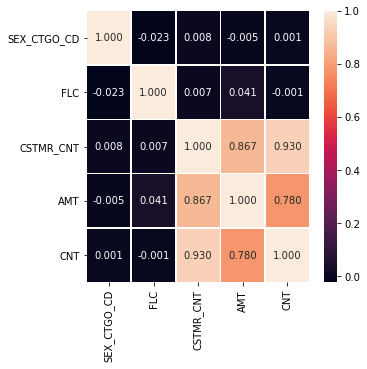

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.3f', linewidths=.5)

분석 결과 CSTMR_CNT와 CNT를 제외한 변수들은 AMT와의 상관도가 낮다.

In [10]:
DF = df.copy() 
DF = DF.drop(['HOM_SIDO_NM','CARD_CCG_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD', 'FLC','CSTMR_CNT','CNT'], axis=1)

In [11]:
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048114 rows x 4 columns]

#### 4) 이상한 데이터 제거

In [12]:
DF[DF['AMT']<2000]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM   AMT
234726   2019-01-01           경기           기타 대형 종합 소매업   900
877390   2019-01-01           서울              내항 여객 운송업   500
1001180  2019-01-01           서울                수산물 소매업  1000
1423635  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    40
1423637  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    90
...             ...          ...                    ...   ...
24126444 2020-03-01           서울  피자 햄버거 샌드위치 및 유사 음식점업  1600
24593106 2020-03-01           제주              정기 항공 운송업   300
63288    2020-04-01           경기           기타 대형 종합 소매업  1230
780409   2020-04-01           서울           그외 기타 종합 소매업  1600
1185267  2020-04-01           전북            차량용 주유소 운영업    30

[94 rows x 4 columns]

In [13]:
idx = DF[DF['AMT']<2000].index
DF = DF.drop(idx)
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048014 rows x 4 columns]

40원, 90원등 작은 금액이 결제된 데이터들이 보여 2000원 미만으로 결제된 목록을 알아보았다.

이상치를 완전히 제거하기 위해 2000원 미만의 데이터들을 삭제하였다.

#### 6) 데이터 묶음

In [14]:
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM','REG_YYMM']
DF = DF.groupby(columns).sum().reset_index(drop=False)
DF

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM        AMT
0               강원  건강보조식품 소매업 2019-01-01  148354746
1               강원  건강보조식품 소매업 2019-02-01  146715871
2               강원  건강보조식품 소매업 2019-03-01  109439025
3               강원  건강보조식품 소매업 2019-04-01  106548473
4               강원  건강보조식품 소매업 2019-05-01  148115738
...            ...         ...        ...        ...
10043           충북    휴양콘도 운영업 2019-12-01  139568962
10044           충북    휴양콘도 운영업 2020-01-01  222073112
10045           충북    휴양콘도 운영업 2020-02-01   47085830
10046           충북    휴양콘도 운영업 2020-03-01   12733490
10047           충북    휴양콘도 운영업 2020-04-01    9328420

[10048 rows x 4 columns]

#### 7) 업종 별 결측값 확인

In [15]:
len_STD = pd.DataFrame(data = DF['STD_CLSS_NM'].value_counts())
len_STD = len_STD[len_STD['STD_CLSS_NM'] < 272]
len_STD

STD_CLSS_NM
마사지업                          271
관광 민예품 및 선물용품 소매업             270
호텔업                           255
그외 기타 스포츠시설 운영업               253
자동차 임대업                       248
기타 수상오락 서비스업                  227
여행사업                          215
택시 운송업                        189
내항 여객 운송업                     179
버스 운송업                        175
휴양콘도 운영업                      160
면세점                           112
정기 항공 운송업                      92
그외 기타 분류안된 오락관련 서비스업           58

2019년 1월부터 2020년 4월까지의 데이터가 모두 존재하면 272개 이다.

지역별로 없는 업종이 존재하는 걸로 보인다.

In [16]:
len_CARD = pd.DataFrame()
for index in len_STD.index:
    DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == index])
    len_CARD[index] = DF_sample['CARD_SIDO_NM'].value_counts()
len_CARD

마사지업  관광 민예품 및 선물용품 소매업   호텔업  그외 기타 스포츠시설 운영업  자동차 임대업  기타 수상오락 서비스업  \
경기    16                 16  16.0               16     16.0            16   
서울    16                 16  16.0               16     16.0            16   
부산    16                 16  16.0               16     16.0            16   
전남    16                 16  16.0               16     16.0             2   
경북    16                 16  16.0               16     16.0            16   
대전    16                 16  16.0               16     15.0            12   
경남    16                 16  16.0               16     15.0            16   
제주    16                 16  16.0               12     16.0             9   
충남    16                 16  16.0               16     13.0            16   
광주    16                 16  16.0               16     16.0            14   
울산    16                 16  16.0               16     16.0            15   
대구    16                 16  16.0               16     16.0            16   
강원    16                 16  16.0               16     16.0            16   
전북    16                 16  15.0               16     16.0            14   
충북    16                 16  16.0               16     14.0            16   
인천    16                 16  16.0               16     15.0            16   
세종    15                 14   NaN                1      NaN             1   

    여행사업  택시 운송업  내항 여객 운송업  버스 운송업  휴양콘도 운영업   면세점  정기 항공 운송업  \
경기  16.0    16.0       11.0    16.0      16.0   NaN        NaN   
서울  16.0    16.0       16.0    16.0       NaN  16.0       16.0   
부산  16.0    16.0       14.0    15.0      16.0  15.0       16.0   
전남  16.0     1.0       16.0    16.0      16.0  14.0        NaN   
경북  12.0    16.0       13.0    13.0      16.0   NaN        NaN   
대전   1.0     NaN        NaN     NaN       NaN   NaN        NaN   
경남  16.0    16.0       16.0    16.0      16.0   NaN        NaN   
제주  16.0     7.0       16.0     NaN      16.0  16.0       16.0   
충남  16.0     9.0       14.0     8.0      16.0   NaN       12.0   
광주  10.0    11.0       13.0    16.0       NaN   NaN        NaN   
울산  16.0     3.0        NaN    16.0       NaN   8.0        NaN   
대구  11.0    16.0        NaN     8.0       NaN  14.0        NaN   
강원  16.0    14.0       16.0    13.0      16.0   5.0        NaN   
전북  16.0    16.0        6.0    15.0      16.0   NaN       16.0   
충북   5.0    16.0       12.0     7.0      16.0   8.0        NaN   
인천  16.0    16.0       16.0     NaN       NaN  16.0       16.0   
세종   NaN     NaN        NaN     NaN       NaN   NaN        NaN   

    그외 기타 분류안된 오락관련 서비스업  
경기                   4.0  
서울                   NaN  
부산                   NaN  
전남                   3.0  
경북                   5.0  
대전                   NaN  
경남                  16.0  
제주                  10.0  
충남                  16.0  
광주                   NaN  
울산                   2.0  
대구                   NaN  
강원                   1.0  
전북                   NaN  
충북                   NaN  
인천                   NaN  
세종                   1.0

In [17]:
for col in len_CARD.columns:
    print(len_CARD[(len_CARD[col] < 16)].index, col)

Index(['세종'], dtype='object') 마사지업
Index(['세종'], dtype='object') 관광 민예품 및 선물용품 소매업
Index(['전북'], dtype='object') 호텔업
Index(['제주', '세종'], dtype='object') 그외 기타 스포츠시설 운영업
Index(['대전', '경남', '충남', '충북', '인천'], dtype='object') 자동차 임대업
Index(['전남', '대전', '제주', '광주', '울산', '전북', '세종'], dtype='object') 기타 수상오락 서비스업
Index(['경북', '대전', '광주', '대구', '충북'], dtype='object') 여행사업
Index(['전남', '제주', '충남', '광주', '울산', '강원'], dtype='object') 택시 운송업
Index(['경기', '부산', '경북', '충남', '광주', '전북', '충북'], dtype='object') 내항 여객 운송업
Index(['부산', '경북', '충남', '대구', '강원', '전북', '충북'], dtype='object') 버스 운송업
Index([], dtype='object') 휴양콘도 운영업
Index(['부산', '전남', '울산', '대구', '강원', '충북'], dtype='object') 면세점
Index(['충남'], dtype='object') 정기 항공 운송업
Index(['경기', '전남', '경북', '제주', '울산', '강원', '세종'], dtype='object') 그외 기타 분류안된 오락관련 서비스업


# 경남
 - 12미만 없음.

# 광주 
 - 광주 - 여행사업 2019년 6, 8, 9월 2020년 1, 2, 4월 비어있음.
 - 광주 - 택시운송업 2019년  1, 2월 2020년 2, 3, 4월 비어있음.
 
# 경기
 - 경기 - 내항여객 운송업 2019년 1, 2,12월 2020년 1, 2월
 - 경기 - 그 외 기타 분류x 2019년 1,2,3,4.8.10,11,12월 2020년 2,3,4월

# 인천
 - 12미만 없음.

# 울산
 - 울산 - 택시운송업 2019년 1 ~ 9월, 11월 2020년 1, 3, 4월
 - 울산 - 면세점 2019년 3,8,9,10월 2020년 1,2,3,4월 비었음
 - 울산 - 그외 분류x  2019년 7,8월만 있음.

# 서울
 - 12미만 없음.

# 대전
 - 대전 - 기타 수상오락 서비스업 2019년 11월 2020년 1,2,4월
 - 대전 - 여행사업 2019년 2월 자료만 있음.

# 전남
 - 전남 - 기타수상오락 서비스업 2019년 7,8월만 존재
 - 전남 - 택시운송업 2019년 5월 데이터만 존재
 - 전남 - 그 외 기타 분류 x 2019년 2, 5, 7월만 있음.

# 제주
 - 제주 - 택시운송업 19년 1 ~ 8월 데이터 비었음.
 - 제주 - 그 외 기타 분류x 2019년 1 ~ 6월 비어있음

# 충남
 - 충남 - 버스 운송업 2019년 1 ~ 8월데이터 비어있음.
 - 충남 - 정기 항공 운송업 2020년 1,2,3,4월 비어있음.
 - 충남 - 택시 운송업 19년 3, 11, 12월 20년 1,2,3,4월 비었음

# 부산
 - 12미만 없음.

# 전북
 - 12미만 없음.

# 강원
 - 강원 - 면세점 2019년 1, 4, 7월 2020년 1, 2월만 존재
 - 강원 - 그외 기타 분류x 2019년 5월만 존재

# 경북
 - 경북 - 여행사업 2019넌 2, 4, 9, 10월 빔.
 - 경북 - 그 외 기타 분류x 2019년 2, 7 ~ 12월 / 2020년 1,2,3,4월 비었음.
 
# 충북
 - 충북 - 여행사업 2019년 1,2, 8 ~ 12월 2020년 1,2,3,4월 비었음.
 - 충북 - 버스 운송업 2019년 2, 3, 10 ~ 12월, 2020년 1,2,3,4월 비었음.
 - 충북 - 면세점 2019년 5 ~ 9월 2020년 3, 4월 비었음.

# 대구
 - 대구 - 여행사업 2019년 11월 / 2020년 1,2,3,4월 비었음
 - 대구 - 버스운송업 2019년 9 ~ 12월 / 2020년 1,2,3,4월.

# 세종
 - 세종 - 그 외 기타 스포츠 시설 2020년 1월 데이터만 존재.
 - 세종 - 기타수상오락 서비스업 2019년 1월만 존재
 - 세종 - 그외 기타 분류x 2019년 5월 데이터만 존재.

In [18]:
temp = DF.copy()

# 경남

# 12 미만 없음

# 광주

In [19]:
temp_gwangju = temp[temp.CARD_SIDO_NM == '광주']

In [21]:
# 광주 - 여행사업 2019년 6, 8, 9월 2020년 1, 2, 4월 비어있음.
temp_gwangju[temp_gwangju.STD_CLSS_NM == '여행사업']

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM      AMT
2773           광주        여행사업 2019-01-01  1200000
2774           광주        여행사업 2019-02-01  2800000
2775           광주        여행사업 2019-03-01  2345000
2776           광주        여행사업 2019-04-01  3057400
2777           광주        여행사업 2019-05-01  5123000
2778           광주        여행사업 2019-07-01  7128000
2779           광주        여행사업 2019-10-01  7321644
2780           광주        여행사업 2019-11-01   123700
2781           광주        여행사업 2019-12-01  1000000
2782           광주        여행사업 2020-02-01  4040200

In [22]:
# 광주 - 택시운송업 2019년  1, 2월 2020년 2, 3, 4월 비어있음.
temp_gwangju[temp_gwangju.STD_CLSS_NM == '택시 운송업']

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM     AMT
2943           광주      택시 운송업 2019-03-01   62300
2944           광주      택시 운송업 2019-04-01   66900
2945           광주      택시 운송업 2019-05-01   41000
2946           광주      택시 운송업 2019-06-01   23600
2947           광주      택시 운송업 2019-07-01   18800
2948           광주      택시 운송업 2019-08-01   33900
2949           광주      택시 운송업 2019-09-01  196500
2950           광주      택시 운송업 2019-10-01  493900
2951           광주      택시 운송업 2019-11-01  121000
2952           광주      택시 운송업 2019-12-01  112700
2953           광주      택시 운송업 2020-01-01   73500

# 경기

In [35]:
temp_gyunggi = temp[temp.CARD_SIDO_NM == '경기']

In [36]:
# 경기 - 내항여객 운송업 2019년 1, 2,12월 2020년 1, 2월
temp_gyunggi[temp_gyunggi.STD_CLSS_NM == '내항 여객 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
1307 2019-03-01           경기   내항 여객 운송업            2    7          7   
1938 2019-04-01           경기   내항 여객 운송업            8   23         23   
2572 2019-05-01           경기   내항 여객 운송업           17   55         52   
3207 2019-06-01           경기   내항 여객 운송업           13   37         46   
3841 2019-07-01           경기   내항 여객 운송업           13   40         43   
4478 2019-08-01           경기   내항 여객 운송업           19   63         69   
5111 2019-09-01           경기   내항 여객 운송업           10   33         28   
5737 2019-10-01           경기   내항 여객 운송업           15   40         41   
6368 2019-11-01           경기   내항 여객 운송업            1    4          3   
8876 2020-03-01           경기   내항 여객 운송업            3    9         12   
9486 2020-04-01           경기   내항 여객 운송업            8   17         23   

          AMT  CNT  
1307   213000    7  
1938  1156500   25  
2572  2272100   55  
3207  1691500   47  
3841  1770000   49  
4478  3537500   74  
5111  1410000   29  
5737  2530000   43  
6368   410000    3  
8876   261500   13  
9486   589500   25

In [39]:
# 경기 - 그 외 기타 분류x 2019년 1,2,3,4.8.10,11,12월 2020년 2,3,4월
temp_gyunggi[temp_gyunggi.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
2564 2019-05-01           경기  그외 기타 분류안된 오락관련 서비스업            1    1   
3833 2019-07-01           경기  그외 기타 분류안된 오락관련 서비스업            3    2   
5103 2019-09-01           경기  그외 기타 분류안된 오락관련 서비스업            1    2   
8249 2020-02-01           경기  그외 기타 분류안된 오락관련 서비스업            2    1   

      CSTMR_CNT     AMT  CNT  
2564          3  135000    4  
3833          6  187000    8  
5103          3   80000    3  
8249          3   45000    3

# 인천

# NaN 결측치만 있음.

# 울산

In [37]:
temp_ulsan = temp[temp.CARD_SIDO_NM == '울산']

In [38]:
# 울산 - 택시운송업 2019년 1 ~ 9월, 11월 2020년 1, 3, 4월
temp_ulsan[temp_ulsan.STD_CLSS_NM == '택시 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT     AMT  \
6085 2019-10-01           울산      택시 운송업            2    3          3   20500   
7344 2019-12-01           울산      택시 운송업            4    9         13   75200   
8600 2020-02-01           울산      택시 운송업            6    9         16  100600   

      CNT  
6085    3  
7344   13  
8600   17

In [40]:
# 울산 - 면세점 2019년 3,8,9,10월 2020년 1,2,3,4월 비었음
temp_ulsan[temp_ulsan.STD_CLSS_NM == '면세점']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
380  2019-01-01           울산         면세점            1    5          3   
1008 2019-02-01           울산         면세점            2    7          6   
2269 2019-04-01           울산         면세점            2    5          3   
2905 2019-05-01           울산         면세점            1    3          3   
3538 2019-06-01           울산         면세점            1    3          4   
4173 2019-07-01           울산         면세점            2    5          3   
6695 2019-11-01           울산         면세점            1    4          3   
7324 2019-12-01           울산         면세점            2    7          6   

          AMT  CNT  
380    550600    3  
1008  2219200    7  
2269   791000    3  
2905  3415890    8  
3538  1109000    9  
4173   418000    4  
6695   846500    5  
7324  1236000    8

In [41]:
# 울산 - 그외 분류x  2019년 7,8월만 있음.
temp_ulsan[temp_ulsan.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
4164 2019-07-01           울산  그외 기타 분류안된 오락관련 서비스업            1    3   
4800 2019-08-01           울산  그외 기타 분류안된 오락관련 서비스업            2    6   

      CSTMR_CNT     AMT  CNT  
4164          3  110000    3  
4800          6  295000    6

# 서울

# 12미만 없음.

# 대전

In [44]:
temp_daejeon = temp[temp.CARD_SIDO_NM == '대전']

In [45]:
# 대전 - 기타 수상오락 서비스업 2019년 11월 2020년 1,2,4월
temp_daejeon[temp_daejeon.STD_CLSS_NM == '기타 수상오락 서비스업']

REG_YYMM CARD_SIDO_NM   STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
233  2019-01-01           대전  기타 수상오락 서비스업            3    5          7   
861  2019-02-01           대전  기타 수상오락 서비스업            2    5          8   
1493 2019-03-01           대전  기타 수상오락 서비스업            2    4          6   
2123 2019-04-01           대전  기타 수상오락 서비스업            1    1          5   
2758 2019-05-01           대전  기타 수상오락 서비스업            3    8         11   
3392 2019-06-01           대전  기타 수상오락 서비스업            4    7         11   
4026 2019-07-01           대전  기타 수상오락 서비스업            2    5         11   
4662 2019-08-01           대전  기타 수상오락 서비스업            1    3          4   
5293 2019-09-01           대전  기타 수상오락 서비스업            3    7         11   
5920 2019-10-01           대전  기타 수상오락 서비스업            1    2          4   
7178 2019-12-01           대전  기타 수상오락 서비스업            3    8          9   
9051 2020-03-01           대전  기타 수상오락 서비스업            1    2          3   

         AMT  CNT  
233   320400    7  
861   652900   14  
1493  239700    8  
2123   91000    5  
2758  514600   15  
3392  350500   12  
4026  435500   12  
4662  143000    4  
5293  277000   11  
5920  129000    5  
7178  329700    9  
9051   94000    3

In [46]:
# 대전 - 여행사업 2019년 2월 자료만 있음.
temp_daejeon[temp_daejeon.STD_CLSS_NM == '여행사업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  \
873 2019-02-01           대전        여행사업            2    2          3  3030000   

     CNT  
873    2

# 전남

In [47]:
temp_jeonam = temp[temp.CARD_SIDO_NM == '전남']

In [48]:
# 전남 - 기타수상오락 서비스업 2019년 7,8월만 존재
temp_jeonam[temp_jeonam.STD_CLSS_NM == '기타 수상오락 서비스업']

REG_YYMM CARD_SIDO_NM   STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
4243 2019-07-01           전남  기타 수상오락 서비스업            1    1          3   
4877 2019-08-01           전남  기타 수상오락 서비스업            4    4         14   

          AMT  CNT  
4243   126000    3  
4877  1563500   14

In [50]:
#; 전남 - 택시운송업 2019년 5월 데이터만 존재
temp_jeonam[temp_jeonam.STD_CLSS_NM == '택시 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT    AMT  \
3000 2019-05-01           전남      택시 운송업            2    1          3  30350   

      CNT  
3000    5

In [51]:
# 전남 - 그 외 기타 분류 x 2019년 2, 5, 7월만 있음.
temp_jeonam[temp_jeonam.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
1074 2019-02-01           전남  그외 기타 분류안된 오락관련 서비스업            1    1   
2971 2019-05-01           전남  그외 기타 분류안된 오락관련 서비스업            1    1   
4239 2019-07-01           전남  그외 기타 분류안된 오락관련 서비스업            2    1   

      CSTMR_CNT     AMT  CNT  
1074          4  136000    4  
2971          3   66000    3  
4239          3  126000    4

# 제주

In [52]:
temp_jeju = temp[temp.CARD_SIDO_NM == '제주']

In [53]:
# 제주 - 택시운송업 19년 1 ~ 8월 데이터 비었음.
temp_jeju[temp_jeju.STD_CLSS_NM == '택시 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT     AMT  \
6237 2019-10-01           제주      택시 운송업            4    6         11   78000   
6865 2019-11-01           제주      택시 운송업            7   12         14   85100   
7496 2019-12-01           제주      택시 운송업            9   18         48  320800   
8125 2020-01-01           제주      택시 운송업           10   21         27  215500   
8750 2020-02-01           제주      택시 운송업           11   23         42  278800   
9361 2020-03-01           제주      택시 운송업           14   25         77  471100   
9970 2020-04-01           제주      택시 운송업           12   24         74  536220   

      CNT  
6237   15  
6865   14  
7496   52  
8125   37  
8750   47  
9361   78  
9970   87

In [54]:
# 제주 - 그 외 기타 분류x 2019년 1 ~ 6월 비어있음.
temp_jeju[temp_jeju.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
4317 2019-07-01           제주  그외 기타 분류안된 오락관련 서비스업           19   23   
4951 2019-08-01           제주  그외 기타 분류안된 오락관련 서비스업           43   47   
5578 2019-09-01           제주  그외 기타 분류안된 오락관련 서비스업           34   39   
6207 2019-10-01           제주  그외 기타 분류안된 오락관련 서비스업           23   31   
6835 2019-11-01           제주  그외 기타 분류안된 오락관련 서비스업           13   15   
7466 2019-12-01           제주  그외 기타 분류안된 오락관련 서비스업           12   16   
8096 2020-01-01           제주  그외 기타 분류안된 오락관련 서비스업           19   25   
8721 2020-02-01           제주  그외 기타 분류안된 오락관련 서비스업           12   12   
9332 2020-03-01           제주  그외 기타 분류안된 오락관련 서비스업            7    5   
9941 2020-04-01           제주  그외 기타 분류안된 오락관련 서비스업            5    4   

      CSTMR_CNT      AMT  CNT  
4317         84  1074370  102  
4951        167  2705670  177  
5578        145  2889650  176  
6207         76  1192000   84  
6835         33   484800   37  
7466         30   396000   31  
8096         52   942350   53  
8721         40   618250   41  
9332         19   313500   20  
9941         13   210300   14

# 충남

In [56]:
temp_choongnam = temp[temp.CARD_SIDO_NM == '충남']

In [57]:
# 충남 - 버스 운송업 2019년 1 ~ 8월데이터 비어있음.
temp_choongnam[temp_choongnam.STD_CLSS_NM == '버스 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT     AMT  \
5626 2019-09-01           충남      버스 운송업           15   29         62  315000   
6257 2019-10-01           충남      버스 운송업           20   39        112  553800   
6885 2019-11-01           충남      버스 운송업           23   50        130  619000   
7516 2019-12-01           충남      버스 운송업           15   32         88  406400   
8145 2020-01-01           충남      버스 운송업           22   45        131  852100   
8770 2020-02-01           충남      버스 운송업           22   43        126  818600   
9380 2020-03-01           충남      버스 운송업           18   32         66  322074   
9989 2020-04-01           충남      버스 운송업           25   49        101  505800   

      CNT  
5626   79  
6257  170  
6885  184  
7516  126  
8145  179  
8770  151  
9380   80  
9989  145

In [59]:
# 충남 - 정기 항공 운송업 2020년 1,2,3,4월 비어있음.
temp_choongnam[temp_choongnam.STD_CLSS_NM == '정기 항공 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
583  2019-01-01           충남   정기 항공 운송업           12   30         42   
1211 2019-02-01           충남   정기 항공 운송업            4   14          9   
1840 2019-03-01           충남   정기 항공 운송업           22   58         56   
2471 2019-04-01           충남   정기 항공 운송업           17   49         53   
3109 2019-05-01           충남   정기 항공 운송업           13   37         29   
3741 2019-06-01           충남   정기 항공 운송업           12   31         28   
4380 2019-07-01           충남   정기 항공 운송업           11   27         25   
5013 2019-08-01           충남   정기 항공 운송업           19   59         48   
5640 2019-09-01           충남   정기 항공 운송업            7   19         18   
6272 2019-10-01           충남   정기 항공 운송업            8   28         20   
6900 2019-11-01           충남   정기 항공 운송업            6   16         13   
7531 2019-12-01           충남   정기 항공 운송업            4    9          7   

           AMT  CNT  
583    9900500   49  
1211   2659000   10  
1840  18347500   57  
2471   8426500   54  
3109   6988000   36  
3741   4435000   30  
4380   6119000   25  
5013   6705500   46  
5640   2271000   20  
6272   1593000   22  
6900   3885000   16  
7531    549000    7

In [53]:
# 충남 - 택시 운송업 19년 3, 11, 12월 20년 1,2,3,4월 비었음
temp_choongnam[temp_choongnam.STD_CLSS_NM == '택시 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT     AMT  \
588  2019-01-01           충남      택시 운송업            8   13         37  194800   
1216 2019-02-01           충남      택시 운송업            4    7         11   71220   
2476 2019-04-01           충남      택시 운송업            1    1          4   64120   
3114 2019-05-01           충남      택시 운송업            2    3         11  129420   
3746 2019-06-01           충남      택시 운송업            3    2         14  117920   
4385 2019-07-01           충남      택시 운송업            8   13         23  197920   
5018 2019-08-01           충남      택시 운송업            4    7         15  124900   
5645 2019-09-01           충남      택시 운송업            5    8         17  269480   
6277 2019-10-01           충남      택시 운송업            1    1          4   26100   

      CNT  
588    37  
1216   11  
2476    4  
3114   12  
3746   14  
4385   25  
5018   16  
5645   20  
6277    4

# 부산

# 12이하 없음

# 전북

# 12이하 없음

# 강원

In [63]:
temp_gangwon = temp[temp.CARD_SIDO_NM == '강원']

In [65]:
# 강원 - 면세점 2019년 1, 4, 7월 2020년 1, 2월만 존재
temp_gangwon[temp_gangwon.STD_CLSS_NM == '면세점']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
13   2019-01-01           강원         면세점            8   30         41   
1901 2019-04-01           강원         면세점            1    4          3   
3803 2019-07-01           강원         면세점            2    6          6   
7591 2020-01-01           강원         면세점            5   13         14   
8219 2020-02-01           강원         면세점            1    4          3   

          AMT  CNT  
13    3501010   56  
1901   113730    4  
3803   431090    9  
7591   625010   16  
8219   147940    3

In [66]:
# 강원 - 그외 기타 분류x 2019년 5월만 존재
temp_gangwon[temp_gangwon.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
2525 2019-05-01           강원  그외 기타 분류안된 오락관련 서비스업            2    6   

      CSTMR_CNT     AMT  CNT  
2525          6  177000   10

# 경북

In [67]:
temp_gyungbuk = temp[temp.CARD_SIDO_NM == '경북']

In [69]:
# 경북 - 여행사업 2019넌 2, 4, 9, 10월 빔.
temp_gyungbuk[temp_gyungbuk.STD_CLSS_NM == '여행사업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
136  2019-01-01           경북        여행사업            2    4          3   
1395 2019-03-01           경북        여행사업            1    4          4   
2660 2019-05-01           경북        여행사업            3   13         12   
3295 2019-06-01           경북        여행사업            1    4          4   
3928 2019-07-01           경북        여행사업            2    3          4   
4565 2019-08-01           경북        여행사업            5   12         11   
6455 2019-11-01           경북        여행사업            3   12         10   
7081 2019-12-01           경북        여행사업            1    5          5   
7714 2020-01-01           경북        여행사업            2    4          3   
8342 2020-02-01           경북        여행사업            2    8          8   
8960 2020-03-01           경북        여행사업            1    4          4   
9571 2020-04-01           경북        여행사업            3   14         10   

          AMT  CNT  
136     89000    3  
1395  1037800    4  
2660  1689900   12  
3295   596000    5  
3928    48500    5  
4565  4170900   11  
6455  5160000   10  
7081   297000    6  
7714   134500    3  
8342  1186000    8  
8960   171000    4  
9571   750000   10

In [68]:
# 경북 - 그 외 기타 분류x 2019년 2, 7 ~ 12월 / 2020년 1,2,3,4월 비었음.
temp_gyungbuk[temp_gyungbuk.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
119  2019-01-01           경북  그외 기타 분류안된 오락관련 서비스업            1    3   
1377 2019-03-01           경북  그외 기타 분류안된 오락관련 서비스업            3    6   
2008 2019-04-01           경북  그외 기타 분류안된 오락관련 서비스업            1    3   
2642 2019-05-01           경북  그외 기타 분류안된 오락관련 서비스업            1    3   
3277 2019-06-01           경북  그외 기타 분류안된 오락관련 서비스업            1    3   

      CSTMR_CNT     AMT  CNT  
119           4  195000    4  
1377          8  290000   10  
2008          3   85000    3  
2642          3  105000    3  
3277          4  135000    4

# 충북

In [70]:
temp_choongbuk = temp[temp.CARD_SIDO_NM == '충북']

In [71]:
# 충북 - 여행사업 2019년 1,2, 8 ~ 12월 2020년 1,2,3,4월 비었음.
temp_choongbuk[temp_choongbuk.STD_CLSS_NM == '여행사업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
1871 2019-03-01           충북        여행사업           21   26         64   
2504 2019-04-01           충북        여행사업            6   10         15   
3141 2019-05-01           충북        여행사업            6   11         17   
3773 2019-06-01           충북        여행사업            2    5          3   
4412 2019-07-01           충북        여행사업            2    5          3   

          AMT  CNT  
1871  6352050   85  
2504   547500   17  
3141   661100   22  
3773   240000    3  
4412   264000    4

In [72]:
# 충북 - 내항여객 운송업 2019년 1, 2월 2020년 2,3월 비었음.
temp_choongbuk[temp_choongbuk.STD_CLSS_NM == '내항 여객 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
1861  2019-03-01           충북   내항 여객 운송업           24   70         60   
2493  2019-04-01           충북   내항 여객 운송업           50  159        133   
3131  2019-05-01           충북   내항 여객 운송업           95  300        286   
3763  2019-06-01           충북   내항 여객 운송업           41  122        101   
4402  2019-07-01           충북   내항 여객 운송업           25   74         65   
5035  2019-08-01           충북   내항 여객 운송업          121  368        368   
5662  2019-09-01           충북   내항 여객 운송업           39  116         99   
6294  2019-10-01           충북   내항 여객 운송업          105  299        311   
6921  2019-11-01           충북   내항 여객 운송업           70  226        197   
7552  2019-12-01           충북   내항 여객 운송업            3   12          9   
8180  2020-01-01           충북   내항 여객 운송업            1    5          3   
10023 2020-04-01           충북   내항 여객 운송업            2    4          3   

            AMT  CNT  
1861    1089000   62  
2493    6770500  148  
3131   11282500  302  
3763    3219500  110  
4402    2092000   67  
5035   14829000  373  
5662    3151000  107  
6294   12018500  325  
6921    7056000  215  
7552     262000    9  
8180      84000    3  
10023     45000    3

In [73]:
# 충북 - 버스 운송업 2019년 2, 3, 10 ~ 12월, 2020년 1,2,3,4월 비었음.
temp_choongbuk[temp_choongbuk.STD_CLSS_NM == '버스 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT     AMT  \
607  2019-01-01           충북      버스 운송업            2    4          3   28000   
2496 2019-04-01           충북      버스 운송업            3    7          6   44000   
3133 2019-05-01           충북      버스 운송업            1    5          4   32000   
3765 2019-06-01           충북      버스 운송업            2    6          6  215000   
4404 2019-07-01           충북      버스 운송업            2    7          6   51000   
5037 2019-08-01           충북      버스 운송업            1    2          3   20000   
5664 2019-09-01           충북      버스 운송업            2    7          6   73000   

      CNT  
607     3  
2496    6  
3133    5  
3765   16  
4404    6  
5037    3  
5664    7

In [74]:
# 충북 - 면세점 2019년 5 ~ 9월 2020년 3, 4월 비었음.
temp_choongbuk[temp_choongbuk.STD_CLSS_NM == '면세점']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
606  2019-01-01           충북         면세점           75  185        254   
1234 2019-02-01           충북         면세점           36  108        108   
1863 2019-03-01           충북         면세점           40  109        127   
2495 2019-04-01           충북         면세점           46   94        121   
6296 2019-10-01           충북         면세점            2    4          3   
7554 2019-12-01           충북         면세점            1    4          3   
8182 2020-01-01           충북         면세점           24   70         66   
8806 2020-02-01           충북         면세점            4   16         14   

           AMT  CNT  
606   24032321  295  
1234   8708970  120  
1863  11137011  142  
2495  11898372  138  
6296    286990    3  
7554    343530    3  
8182   6226010   71  
8806   1064740   14

# 대구

In [75]:
temp_daegu = temp[temp.CARD_SIDO_NM == '대구']

In [77]:
# 대구 - 여행사업 2019년 11월 / 2020년 1,2,3,4월 비었음.
temp_daegu[temp_daegu.STD_CLSS_NM == '여행사업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
210  2019-01-01           대구        여행사업            4   11          9   
838  2019-02-01           대구        여행사업            1    2          3   
1470 2019-03-01           대구        여행사업            2    4         12   
2100 2019-04-01           대구        여행사업            1    4          3   
2735 2019-05-01           대구        여행사업           12   23         35   
3369 2019-06-01           대구        여행사업            2    6          6   
4003 2019-07-01           대구        여행사업            2    6          9   
4639 2019-08-01           대구        여행사업            1    4          3   
5270 2019-09-01           대구        여행사업            2    6          6   
5897 2019-10-01           대구        여행사업            1    2          3   
7155 2019-12-01           대구        여행사업            3    8         10   

           AMT  CNT  
210    8004400    9  
838     350000    3  
1470   1100000    9  
2100   1751000    3  
2735  15880400   32  
3369   4175000    4  
4003  13942000    8  
4639   4300000    3  
5270   1522800    6  
5897    300000    2  
7155   3950000    8

In [78]:
# 대구 - 버스운송업 2019년 9 ~ 12월 / 2020년 1,2,3,4월
temp_daegu[temp_daegu.STD_CLSS_NM == '버스 운송업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
202  2019-01-01           대구      버스 운송업           25   69        112   
830  2019-02-01           대구      버스 운송업           36   87        135   
1462 2019-03-01           대구      버스 운송업           29   79         80   
2092 2019-04-01           대구      버스 운송업           30   77         99   
2727 2019-05-01           대구      버스 운송업           18   49         65   
3361 2019-06-01           대구      버스 운송업           25   67         88   
3995 2019-07-01           대구      버스 운송업           22   66         84   
4631 2019-08-01           대구      버스 운송업           25   64        102   

          AMT  CNT  
202   2823000  241  
830   2944000  259  
1462  1656000  142  
2092  2650000  224  
2727  2153000  150  
3361  2623000  199  
3995  2344000  165  
4631  2527000  211

# 세종

In [79]:
temp_saejong = temp[temp.CARD_SIDO_NM == '세종']

In [81]:
# 세종 - 그 외 기타 스포츠 시설 2020년 1월 데이터만 존재.
temp_saejong[temp_saejong.STD_CLSS_NM == '그외 기타 스포츠시설 운영업']

REG_YYMM CARD_SIDO_NM      STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT  \
7917 2020-01-01           세종  그외 기타 스포츠시설 운영업            1    2          3   

         AMT  CNT  
7917  168000    3

In [82]:
# 세종 - 기타수상오락 서비스업 2019년 1월만 존재.
temp_saejong[temp_saejong.STD_CLSS_NM == '기타 수상오락 서비스업']

REG_YYMM CARD_SIDO_NM   STD_CLSS_NM  SEX_CTGO_CD  FLC  CSTMR_CNT    AMT  \
344 2019-01-01           세종  기타 수상오락 서비스업            1    3          3  68200   

     CNT  
344    3

In [83]:
# 세종 - 그외 기타 분류x 2019년 5월 데이터만 존재.
temp_saejong[temp_saejong.STD_CLSS_NM == '그외 기타 분류안된 오락관련 서비스업']

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM  SEX_CTGO_CD  FLC  \
2867 2019-05-01           세종  그외 기타 분류안된 오락관련 서비스업            2    7   

      CSTMR_CNT     AMT  CNT  
2867          6  236000    6

지역별로 예측을 한 뒤 데이터가 없는 업종은 제외한다.

지역별로 예측을 한 뒤 데이터가 없는 업종은 제외한다.

#### 8) 레이블 인코딩

In [23]:
from sklearn.preprocessing import LabelEncoder

dtypes = DF.dtypes
encoders = {}
for column in DF.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(DF[column])
        encoders[column] = encoder
        
df_num = DF.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(DF[column])

In [24]:
df_num

CARD_SIDO_NM  STD_CLSS_NM   REG_YYMM        AMT
0                 0            0 2019-01-01  148354746
1                 0            0 2019-02-01  146715871
2                 0            0 2019-03-01  109439025
3                 0            0 2019-04-01  106548473
4                 0            0 2019-05-01  148115738
...             ...          ...        ...        ...
10043            16           40 2019-12-01  139568962
10044            16           40 2020-01-01  222073112
10045            16           40 2020-02-01   47085830
10046            16           40 2020-03-01   12733490
10047            16           40 2020-04-01    9328420

[10048 rows x 4 columns]

## 3. Catboost Regressor

In [25]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

train_features = df_num.drop(['AMT'], axis=1)
train_target = np.log1p(df_num['AMT'])
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=0)

In [44]:
model = CatBoostRegressor(iterations=10000,
                          learning_rate=0.07,
                          depth=10,
                          eval_metric='RMSE',
                          random_seed = 42,
                          bagging_temperature = 0.1,
                          od_type='Iter',
                          metric_period = 50,
                          od_wait=25)
pool=Pool(data=X_train,label=y_train)
eval_set=(X_test,y_test)
model.fit(X_train,y_train,use_best_model=True,eval_set=eval_set,verbose=100)

0:	learn: 2.8705104	test: 2.8592972	best: 2.8592972 (0)	total: 4.77ms	remaining: 47.7s
100:	learn: 1.0740797	test: 1.1013933	best: 1.1013933 (100)	total: 425ms	remaining: 41.7s
200:	learn: 0.7293229	test: 0.7895996	best: 0.7895996 (200)	total: 863ms	remaining: 42.1s
300:	learn: 0.5869079	test: 0.6679401	best: 0.6679401 (300)	total: 1.29s	remaining: 41.5s
400:	learn: 0.5052123	test: 0.6020044	best: 0.6020044 (400)	total: 1.7s	remaining: 40.8s
500:	learn: 0.4411228	test: 0.5526827	best: 0.5526827 (500)	total: 2.12s	remaining: 40.2s
600:	learn: 0.3937302	test: 0.5192577	best: 0.5191620 (598)	total: 2.53s	remaining: 39.6s
700:	learn: 0.3575797	test: 0.4969373	best: 0.4969065 (699)	total: 2.95s	remaining: 39.2s
800:	learn: 0.3282464	test: 0.4778237	best: 0.4778237 (800)	total: 3.38s	remaining: 38.8s
900:	learn: 0.3064525	test: 0.4647868	best: 0.4647868 (900)	total: 3.79s	remaining: 38.3s
1000:	learn: 0.2869360	test: 0.4547778	best: 0.4547778 (1000)	total: 4.21s	remaining: 37.9s
1100:	learn:

In [45]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test)
RMSE = mean_squared_error(y_test,preds)**0.5
print(RMSE)

0.4038937582143226


## 5. 예측

In [46]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
REG_YYMMs     = ['2020-07-01']

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for REG_YYMM in REG_YYMMs:
                temp.append([CARD_SIDO_NM, STD_CLSS_NM, REG_YYMM])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns= train_features.columns)
temp['REG_YYMM'] = temp['REG_YYMM'].astype('datetime64[ns]')

In [47]:
temp['CARD_SIDO_NM'] = pd.to_numeric(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = pd.to_numeric(temp['STD_CLSS_NM'])
temp.dtypes

CARD_SIDO_NM             int64
STD_CLSS_NM              int64
REG_YYMM        datetime64[ns]
dtype: object

In [48]:
# CatBoost 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]

In [49]:
temp

REG_YYMM  CARD_SIDO_NM  STD_CLSS_NM           AMT
0   2020-07-01             0            0  9.963755e+07
1   2020-07-01             0            1  2.577008e+09
2   2020-07-01             0            2  1.038903e+09
3   2020-07-01             0            3  1.436410e+07
4   2020-07-01             0            4  6.807300e+04
..         ...           ...          ...           ...
692 2020-07-01            16           37  1.794227e+10
693 2020-07-01            16           38  1.388897e+07
694 2020-07-01            16           39  3.796701e+08
695 2020-07-01            16           40  1.080169e+07
696 2020-07-01            16           30  1.013384e+07

[697 rows x 4 columns]

In [50]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [51]:
temp['REG_YYMM'] = temp['REG_YYMM'].astype(str)
temp['REG_YYMM'] = temp['REG_YYMM'].str[0:4] + temp['REG_YYMM'].str[5:7]
temp

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
0     202007           강원            건강보조식품 소매업  9.963755e+07
1     202007           강원               골프장 운영업  2.577008e+09
2     202007           강원           과실 및 채소 소매업  1.038903e+09
3     202007           강원     관광 민예품 및 선물용품 소매업  1.436410e+07
4     202007           강원  그외 기타 분류안된 오락관련 서비스업  6.807300e+04
..       ...          ...                   ...           ...
692   202007           충북               한식 음식점업  1.794227e+10
693   202007           충북                   호텔업  1.388897e+07
694   202007           충북         화장품 및 방향제 소매업  3.796701e+08
695   202007           충북              휴양콘도 운영업  1.080169e+07
696   202007           충북             정기 항공 운송업  1.013384e+07

[697 rows x 4 columns]

## 6. 정리

In [72]:
len_CARD

마사지업  관광 민예품 및 선물용품 소매업   호텔업  그외 기타 스포츠시설 운영업  자동차 임대업  기타 수상오락 서비스업  \
경기    16                 16  16.0               16     16.0            16   
서울    16                 16  16.0               16     16.0            16   
부산    16                 16  16.0               16     16.0            16   
전남    16                 16  16.0               16     16.0             2   
경북    16                 16  16.0               16     16.0            16   
대전    16                 16  16.0               16     15.0            12   
경남    16                 16  16.0               16     15.0            16   
제주    16                 16  16.0               12     16.0             9   
충남    16                 16  16.0               16     13.0            16   
광주    16                 16  16.0               16     16.0            14   
울산    16                 16  16.0               16     16.0            15   
대구    16                 16  16.0               16     16.0            16   
강원    16                 16  16.0               16     16.0            16   
전북    16                 16  15.0               16     16.0            14   
충북    16                 16  16.0               16     14.0            16   
인천    16                 16  16.0               16     15.0            16   
세종    15                 14   NaN                1      NaN             1   

    여행사업  택시 운송업  내항 여객 운송업  버스 운송업  휴양콘도 운영업   면세점  정기 항공 운송업  \
경기  16.0    16.0       11.0    16.0      16.0   NaN        NaN   
서울  16.0    16.0       16.0    16.0       NaN  16.0       16.0   
부산  16.0    16.0       14.0    15.0      16.0  15.0       16.0   
전남  16.0     1.0       16.0    16.0      16.0  14.0        NaN   
경북  12.0    16.0       13.0    13.0      16.0   NaN        NaN   
대전   1.0     NaN        NaN     NaN       NaN   NaN        NaN   
경남  16.0    16.0       16.0    16.0      16.0   NaN        NaN   
제주  16.0     7.0       16.0     NaN      16.0  16.0       16.0   
충남  16.0     9.0       14.0     8.0      16.0   NaN       12.0   
광주  10.0    11.0       13.0    16.0       NaN   NaN        NaN   
울산  16.0     3.0        NaN    16.0       NaN   8.0        NaN   
대구  11.0    16.0        NaN     8.0       NaN  14.0        NaN   
강원  16.0    14.0       16.0    13.0      16.0   5.0        NaN   
전북  16.0    16.0        6.0    15.0      16.0   NaN       16.0   
충북   5.0    16.0       12.0     7.0      16.0   8.0        NaN   
인천  16.0    16.0       16.0     NaN       NaN  16.0       16.0   
세종   NaN     NaN        NaN     NaN       NaN   NaN        NaN   

    그외 기타 분류안된 오락관련 서비스업  
경기                   4.0  
서울                   NaN  
부산                   NaN  
전남                   3.0  
경북                   5.0  
대전                   NaN  
경남                  16.0  
제주                  10.0  
충남                  16.0  
광주                   NaN  
울산                   2.0  
대구                   NaN  
강원                   1.0  
전북                   NaN  
충북                   NaN  
인천                   NaN  
세종                   1.0

In [54]:
DF_choongnam = DF[DF.CARD_SIDO_NM == '충남']

In [56]:
# 충남 - 버스 운송업 2019년 1 ~ 8월데이터 비어있음.
DF_choongnam[DF_choongnam.STD_CLSS_NM == '버스 운송업']

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM     AMT
9064           충남      버스 운송업 2019-09-01  315000
9065           충남      버스 운송업 2019-10-01  553800
9066           충남      버스 운송업 2019-11-01  619000
9067           충남      버스 운송업 2019-12-01  406400
9068           충남      버스 운송업 2020-01-01  852100
9069           충남      버스 운송업 2020-02-01  818600
9070           충남      버스 운송업 2020-03-01  322074
9071           충남      버스 운송업 2020-04-01  505800

In [57]:
# 충남 - 정기 항공 운송업 2020년 1,2,3,4월 비어있음.
DF_choongnam[DF_choongnam.STD_CLSS_NM == '정기 항공 운송업']

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM       AMT
9293           충남   정기 항공 운송업 2019-01-01   9900500
9294           충남   정기 항공 운송업 2019-02-01   2659000
9295           충남   정기 항공 운송업 2019-03-01  18347500
9296           충남   정기 항공 운송업 2019-04-01   8426500
9297           충남   정기 항공 운송업 2019-05-01   6988000
9298           충남   정기 항공 운송업 2019-06-01   4435000
9299           충남   정기 항공 운송업 2019-07-01   6119000
9300           충남   정기 항공 운송업 2019-08-01   6705500
9301           충남   정기 항공 운송업 2019-09-01   2271000
9302           충남   정기 항공 운송업 2019-10-01   1593000
9303           충남   정기 항공 운송업 2019-11-01   3885000
9304           충남   정기 항공 운송업 2019-12-01    549000

In [58]:
# 충남 - 택시 운송업 19년 3, 11, 12월 20년 1,2,3,4월 비었음
DF_choongnam[DF_choongnam.STD_CLSS_NM == '택시 운송업']

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM     AMT
9369           충남      택시 운송업 2019-01-01  194800
9370           충남      택시 운송업 2019-02-01   71220
9371           충남      택시 운송업 2019-04-01   64120
9372           충남      택시 운송업 2019-05-01  129420
9373           충남      택시 운송업 2019-06-01  117920
9374           충남      택시 운송업 2019-07-01  197920
9375           충남      택시 운송업 2019-08-01  124900
9376           충남      택시 운송업 2019-09-01  269480
9377           충남      택시 운송업 2019-10-01   26100

# 충남
 - 충남 - 버스 운송업 2019년 1 ~ 8월데이터 비어있음.
 - 충남 - 정기 항공 운송업 2020년 1,2,3,4월 비어있음.
 - 충남 - 택시 운송업 19년 3, 11, 12월 20년 1,2,3,4월 비었음
 - 충남 - 면세점 데이터 없음
 
**충남 - 정기 항공 운송업, 면세점 데이터 삭제**

In [60]:
#index = 629, 655
temp[(temp['CARD_SIDO_NM'] == '충남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
615   202007           충남             건강보조식품 소매업  6.963433e+08
616   202007           충남                골프장 운영업  1.816608e+09
617   202007           충남            과실 및 채소 소매업  1.491215e+09
618   202007           충남      관광 민예품 및 선물용품 소매업  2.794760e+07
619   202007           충남   그외 기타 분류안된 오락관련 서비스업  1.345740e+05
620   202007           충남        그외 기타 스포츠시설 운영업  8.006610e+05
621   202007           충남           그외 기타 종합 소매업  2.020691e+09
622   202007           충남           기타 대형 종합 소매업  9.842637e+09
623   202007           충남           기타 수상오락 서비스업  3.536721e+06
624   202007           충남            기타 외국식 음식점업  1.286391e+09
625   202007           충남                 기타 주점업  1.469270e+08
626   202007           충남          기타음식료품위주종합소매업  7.525761e+09
627   202007           충남              내항 여객 운송업  1.520040e+05
628   202007           충남                   마사지업  2.163737e+07
629   202007           충남                    면세점  1.706646e+08
630   202007           충남                 버스 운송업  4.431370e+05
631   202007           충남               비알콜 음료점업  1.557093e+09
632   202007           충남            빵 및 과자류 소매업  2.177601e+09
633   202007           충남               서양식 음식점업  2.450105e+09
634   202007           충남                수산물 소매업  1.339784e+09
635   202007           충남                   슈퍼마켓  1.610972e+10
636   202007           충남     스포츠 및 레크레이션 용품 임대업  3.142982e+09
637   202007           충남                    여관업  3.876486e+08
638   202007           충남                   여행사업  5.859210e+06
639   202007           충남                    욕탕업  2.312440e+08
640   202007           충남                 육류 소매업  2.790592e+09
641   202007           충남               일반유흥 주점업  7.163536e+08
642   202007           충남                일식 음식점업  1.221434e+09
643   202007           충남                자동차 임대업  5.780140e+05
644   202007           충남            전시 및 행사 대행업  1.678638e+07
645   202007           충남                중식 음식점업  2.162059e+09
646   202007           충남             차량용 가스 충전업  8.983123e+08
647   202007           충남            차량용 주유소 운영업  2.912312e+10
648   202007           충남                체인화 편의점  1.329532e+10
649   202007           충남                 택시 운송업  1.517556e+06
650   202007           충남  피자 햄버거 샌드위치 및 유사 음식점업  2.189635e+09
651   202007           충남                한식 음식점업  2.780560e+10
652   202007           충남                    호텔업  2.556932e+07
653   202007           충남          화장품 및 방향제 소매업  1.030176e+09
654   202007           충남               휴양콘도 운영업  4.838844e+07
655   202007           충남              정기 항공 운송업  5.780274e+06

In [69]:
temp.iloc[629,3] = 0
temp.iloc[655,3] = 0

In [70]:
temp[(temp['CARD_SIDO_NM'] == '충남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
615   202007           충남             건강보조식품 소매업  6.963433e+08
616   202007           충남                골프장 운영업  1.816608e+09
617   202007           충남            과실 및 채소 소매업  1.491215e+09
618   202007           충남      관광 민예품 및 선물용품 소매업  2.794760e+07
619   202007           충남   그외 기타 분류안된 오락관련 서비스업  1.345740e+05
620   202007           충남        그외 기타 스포츠시설 운영업  8.006610e+05
621   202007           충남           그외 기타 종합 소매업  2.020691e+09
622   202007           충남           기타 대형 종합 소매업  9.842637e+09
623   202007           충남           기타 수상오락 서비스업  3.536721e+06
624   202007           충남            기타 외국식 음식점업  1.286391e+09
625   202007           충남                 기타 주점업  1.469270e+08
626   202007           충남          기타음식료품위주종합소매업  7.525761e+09
627   202007           충남              내항 여객 운송업  1.520040e+05
628   202007           충남                   마사지업  2.163737e+07
629   202007           충남                    면세점  0.000000e+00
630   202007           충남                 버스 운송업  4.431370e+05
631   202007           충남               비알콜 음료점업  1.557093e+09
632   202007           충남            빵 및 과자류 소매업  2.177601e+09
633   202007           충남               서양식 음식점업  2.450105e+09
634   202007           충남                수산물 소매업  1.339784e+09
635   202007           충남                   슈퍼마켓  1.610972e+10
636   202007           충남     스포츠 및 레크레이션 용품 임대업  3.142982e+09
637   202007           충남                    여관업  3.876486e+08
638   202007           충남                   여행사업  5.859210e+06
639   202007           충남                    욕탕업  2.312440e+08
640   202007           충남                 육류 소매업  2.790592e+09
641   202007           충남               일반유흥 주점업  7.163536e+08
642   202007           충남                일식 음식점업  1.221434e+09
643   202007           충남                자동차 임대업  5.780140e+05
644   202007           충남            전시 및 행사 대행업  1.678638e+07
645   202007           충남                중식 음식점업  2.162059e+09
646   202007           충남             차량용 가스 충전업  8.983123e+08
647   202007           충남            차량용 주유소 운영업  2.912312e+10
648   202007           충남                체인화 편의점  1.329532e+10
649   202007           충남                 택시 운송업  1.517556e+06
650   202007           충남  피자 햄버거 샌드위치 및 유사 음식점업  2.189635e+09
651   202007           충남                한식 음식점업  2.780560e+10
652   202007           충남                    호텔업  2.556932e+07
653   202007           충남          화장품 및 방향제 소매업  1.030176e+09
654   202007           충남               휴양콘도 운영업  4.838844e+07
655   202007           충남              정기 항공 운송업  0.000000e+00

# 경남
 - 12미만 데이터 없음.
 - 면세점, 정기 항공 운송업 데이터 없음
 
**경남 - 정기 항공 운송업, 면세점 데이터 삭제**

In [74]:
#index = 96, 122
temp[(temp['CARD_SIDO_NM'] == '경남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
82    202007           경남             건강보조식품 소매업  3.034550e+08
83    202007           경남                골프장 운영업  5.596973e+09
84    202007           경남            과실 및 채소 소매업  3.386164e+09
85    202007           경남      관광 민예품 및 선물용품 소매업  5.170117e+07
86    202007           경남   그외 기타 분류안된 오락관련 서비스업  4.257440e+05
87    202007           경남        그외 기타 스포츠시설 운영업  8.922680e+05
88    202007           경남           그외 기타 종합 소매업  1.141679e+09
89    202007           경남           기타 대형 종합 소매업  1.907485e+10
90    202007           경남           기타 수상오락 서비스업  1.380403e+06
91    202007           경남            기타 외국식 음식점업  1.601632e+09
92    202007           경남                 기타 주점업  5.755392e+08
93    202007           경남          기타음식료품위주종합소매업  1.523655e+10
94    202007           경남              내항 여객 운송업  2.711025e+07
95    202007           경남                   마사지업  3.817932e+07
96    202007           경남                    면세점  6.090500e+05
97    202007           경남                 버스 운송업  1.040850e+06
98    202007           경남               비알콜 음료점업  2.830631e+09
99    202007           경남            빵 및 과자류 소매업  3.568406e+09
100   202007           경남               서양식 음식점업  4.389688e+09
101   202007           경남                수산물 소매업  1.142601e+09
102   202007           경남                   슈퍼마켓  2.992454e+10
103   202007           경남     스포츠 및 레크레이션 용품 임대업  4.545641e+09
104   202007           경남                    여관업  5.929820e+08
105   202007           경남                   여행사업  1.043190e+05
106   202007           경남                    욕탕업  6.039969e+08
107   202007           경남                 육류 소매업  6.370822e+09
108   202007           경남               일반유흥 주점업  3.122269e+09
109   202007           경남                일식 음식점업  2.169095e+09
110   202007           경남                자동차 임대업  4.248614e+06
111   202007           경남            전시 및 행사 대행업  3.940672e+07
112   202007           경남                중식 음식점업  2.626938e+09
113   202007           경남             차량용 가스 충전업  1.260592e+09
114   202007           경남            차량용 주유소 운영업  3.989486e+10
115   202007           경남                체인화 편의점  2.054485e+10
116   202007           경남                 택시 운송업  1.275405e+07
117   202007           경남  피자 햄버거 샌드위치 및 유사 음식점업  3.979157e+09
118   202007           경남                한식 음식점업  4.963355e+10
119   202007           경남                    호텔업  1.949677e+07
120   202007           경남          화장품 및 방향제 소매업  1.363966e+09
121   202007           경남               휴양콘도 운영업  6.723661e+07
122   202007           경남              정기 항공 운송업  4.406373e+08

In [75]:
temp.iloc[96,3] = 0
temp.iloc[122,3] = 0

In [76]:
temp[(temp['CARD_SIDO_NM'] == '경남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
82    202007           경남             건강보조식품 소매업  3.034550e+08
83    202007           경남                골프장 운영업  5.596973e+09
84    202007           경남            과실 및 채소 소매업  3.386164e+09
85    202007           경남      관광 민예품 및 선물용품 소매업  5.170117e+07
86    202007           경남   그외 기타 분류안된 오락관련 서비스업  4.257440e+05
87    202007           경남        그외 기타 스포츠시설 운영업  8.922680e+05
88    202007           경남           그외 기타 종합 소매업  1.141679e+09
89    202007           경남           기타 대형 종합 소매업  1.907485e+10
90    202007           경남           기타 수상오락 서비스업  1.380403e+06
91    202007           경남            기타 외국식 음식점업  1.601632e+09
92    202007           경남                 기타 주점업  5.755392e+08
93    202007           경남          기타음식료품위주종합소매업  1.523655e+10
94    202007           경남              내항 여객 운송업  2.711025e+07
95    202007           경남                   마사지업  3.817932e+07
96    202007           경남                    면세점  0.000000e+00
97    202007           경남                 버스 운송업  1.040850e+06
98    202007           경남               비알콜 음료점업  2.830631e+09
99    202007           경남            빵 및 과자류 소매업  3.568406e+09
100   202007           경남               서양식 음식점업  4.389688e+09
101   202007           경남                수산물 소매업  1.142601e+09
102   202007           경남                   슈퍼마켓  2.992454e+10
103   202007           경남     스포츠 및 레크레이션 용품 임대업  4.545641e+09
104   202007           경남                    여관업  5.929820e+08
105   202007           경남                   여행사업  1.043190e+05
106   202007           경남                    욕탕업  6.039969e+08
107   202007           경남                 육류 소매업  6.370822e+09
108   202007           경남               일반유흥 주점업  3.122269e+09
109   202007           경남                일식 음식점업  2.169095e+09
110   202007           경남                자동차 임대업  4.248614e+06
111   202007           경남            전시 및 행사 대행업  3.940672e+07
112   202007           경남                중식 음식점업  2.626938e+09
113   202007           경남             차량용 가스 충전업  1.260592e+09
114   202007           경남            차량용 주유소 운영업  3.989486e+10
115   202007           경남                체인화 편의점  2.054485e+10
116   202007           경남                 택시 운송업  1.275405e+07
117   202007           경남  피자 햄버거 샌드위치 및 유사 음식점업  3.979157e+09
118   202007           경남                한식 음식점업  4.963355e+10
119   202007           경남                    호텔업  1.949677e+07
120   202007           경남          화장품 및 방향제 소매업  1.363966e+09
121   202007           경남               휴양콘도 운영업  6.723661e+07
122   202007           경남              정기 항공 운송업  0.000000e+00

# 광주
 - 12미만 데이터 없음.
 - 휴양 콘도 운영업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**광주 - 휴양 콘도 운영업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 삭제**

In [78]:
#index = 203, 204, 178, 168
temp[(temp['CARD_SIDO_NM'] == '광주')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
164   202007           광주             건강보조식품 소매업  2.459614e+08
165   202007           광주                골프장 운영업  2.667487e+08
166   202007           광주            과실 및 채소 소매업  2.245238e+09
167   202007           광주      관광 민예품 및 선물용품 소매업  1.750115e+07
168   202007           광주   그외 기타 분류안된 오락관련 서비스업  5.394040e+05
169   202007           광주        그외 기타 스포츠시설 운영업  6.893600e+05
170   202007           광주           그외 기타 종합 소매업  1.564294e+09
171   202007           광주           기타 대형 종합 소매업  9.547438e+09
172   202007           광주           기타 수상오락 서비스업  1.331040e+05
173   202007           광주            기타 외국식 음식점업  7.604174e+08
174   202007           광주                 기타 주점업  3.192932e+08
175   202007           광주          기타음식료품위주종합소매업  1.235896e+09
176   202007           광주              내항 여객 운송업  3.567565e+06
177   202007           광주                   마사지업  6.185716e+07
178   202007           광주                    면세점  3.083405e+06
179   202007           광주                 버스 운송업  7.144297e+06
180   202007           광주               비알콜 음료점업  2.308433e+09
181   202007           광주            빵 및 과자류 소매업  2.490806e+09
182   202007           광주               서양식 음식점업  3.147868e+09
183   202007           광주                수산물 소매업  1.154718e+09
184   202007           광주                   슈퍼마켓  2.513115e+10
185   202007           광주     스포츠 및 레크레이션 용품 임대업  3.447342e+09
186   202007           광주                    여관업  3.912825e+08
187   202007           광주                   여행사업  3.637370e+05
188   202007           광주                    욕탕업  2.491429e+08
189   202007           광주                 육류 소매업  4.079679e+09
190   202007           광주               일반유흥 주점업  6.561580e+08
191   202007           광주                일식 음식점업  8.260382e+08
192   202007           광주                자동차 임대업  1.277659e+06
193   202007           광주            전시 및 행사 대행업  7.117461e+06
194   202007           광주                중식 음식점업  1.628956e+09
195   202007           광주             차량용 가스 충전업  8.460817e+08
196   202007           광주            차량용 주유소 운영업  1.475663e+10
197   202007           광주                체인화 편의점  9.003863e+09
198   202007           광주                 택시 운송업  2.749320e+05
199   202007           광주  피자 햄버거 샌드위치 및 유사 음식점업  2.123483e+09
200   202007           광주                한식 음식점업  2.798239e+10
201   202007           광주                    호텔업  2.854312e+07
202   202007           광주          화장품 및 방향제 소매업  9.191017e+08
203   202007           광주               휴양콘도 운영업  3.176607e+07
204   202007           광주              정기 항공 운송업  1.278815e+08

In [79]:
temp.iloc[203,3] = 0
temp.iloc[204,3] = 0
temp.iloc[178,3] = 0
temp.iloc[168,3] = 0

In [80]:
temp[(temp['CARD_SIDO_NM'] == '광주')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
164   202007           광주             건강보조식품 소매업  2.459614e+08
165   202007           광주                골프장 운영업  2.667487e+08
166   202007           광주            과실 및 채소 소매업  2.245238e+09
167   202007           광주      관광 민예품 및 선물용품 소매업  1.750115e+07
168   202007           광주   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
169   202007           광주        그외 기타 스포츠시설 운영업  6.893600e+05
170   202007           광주           그외 기타 종합 소매업  1.564294e+09
171   202007           광주           기타 대형 종합 소매업  9.547438e+09
172   202007           광주           기타 수상오락 서비스업  1.331040e+05
173   202007           광주            기타 외국식 음식점업  7.604174e+08
174   202007           광주                 기타 주점업  3.192932e+08
175   202007           광주          기타음식료품위주종합소매업  1.235896e+09
176   202007           광주              내항 여객 운송업  3.567565e+06
177   202007           광주                   마사지업  6.185716e+07
178   202007           광주                    면세점  0.000000e+00
179   202007           광주                 버스 운송업  7.144297e+06
180   202007           광주               비알콜 음료점업  2.308433e+09
181   202007           광주            빵 및 과자류 소매업  2.490806e+09
182   202007           광주               서양식 음식점업  3.147868e+09
183   202007           광주                수산물 소매업  1.154718e+09
184   202007           광주                   슈퍼마켓  2.513115e+10
185   202007           광주     스포츠 및 레크레이션 용품 임대업  3.447342e+09
186   202007           광주                    여관업  3.912825e+08
187   202007           광주                   여행사업  3.637370e+05
188   202007           광주                    욕탕업  2.491429e+08
189   202007           광주                 육류 소매업  4.079679e+09
190   202007           광주               일반유흥 주점업  6.561580e+08
191   202007           광주                일식 음식점업  8.260382e+08
192   202007           광주                자동차 임대업  1.277659e+06
193   202007           광주            전시 및 행사 대행업  7.117461e+06
194   202007           광주                중식 음식점업  1.628956e+09
195   202007           광주             차량용 가스 충전업  8.460817e+08
196   202007           광주            차량용 주유소 운영업  1.475663e+10
197   202007           광주                체인화 편의점  9.003863e+09
198   202007           광주                 택시 운송업  2.749320e+05
199   202007           광주  피자 햄버거 샌드위치 및 유사 음식점업  2.123483e+09
200   202007           광주                한식 음식점업  2.798239e+10
201   202007           광주                    호텔업  2.854312e+07
202   202007           광주          화장품 및 방향제 소매업  9.191017e+08
203   202007           광주               휴양콘도 운영업  0.000000e+00
204   202007           광주              정기 항공 운송업  0.000000e+00

# 경기
 - 경기 - 내항여객 운송업 2019년 1, 2,12월 2020년 1, 2월
 - 경기 - 그 외 기타 분류x 2019년 1,2,3,4.8.10,11,12월 2020년 2,3,4월
 - 면세점, 정기 항공 운송업 데이터 없음
 
**경기 - 내항여객 운송업, 그외 기타 분류안된 오락관련 서비스업, 면세점, 정기 항공 운송업 데이터 삭제**

In [82]:
#index = 45, 53, 55, 81
temp[(temp['CARD_SIDO_NM'] == '경기')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
41   202007           경기             건강보조식품 소매업  1.372107e+09
42   202007           경기                골프장 운영업  1.796725e+10
43   202007           경기            과실 및 채소 소매업  9.574924e+09
44   202007           경기      관광 민예품 및 선물용품 소매업  1.383097e+08
45   202007           경기   그외 기타 분류안된 오락관련 서비스업  2.630280e+05
46   202007           경기        그외 기타 스포츠시설 운영업  6.798573e+06
47   202007           경기           그외 기타 종합 소매업  9.841303e+09
48   202007           경기           기타 대형 종합 소매업  1.509993e+11
49   202007           경기           기타 수상오락 서비스업  5.325525e+07
50   202007           경기            기타 외국식 음식점업  1.098187e+10
51   202007           경기                 기타 주점업  1.519734e+09
52   202007           경기          기타음식료품위주종합소매업  2.080859e+10
53   202007           경기              내항 여객 운송업  9.574140e+05
54   202007           경기                   마사지업  3.239281e+08
55   202007           경기                    면세점  1.042843e+07
56   202007           경기                 버스 운송업  3.125974e+09
57   202007           경기               비알콜 음료점업  1.439810e+10
58   202007           경기            빵 및 과자류 소매업  1.572022e+10
59   202007           경기               서양식 음식점업  2.130622e+10
60   202007           경기                수산물 소매업  4.945014e+09
61   202007           경기                   슈퍼마켓  1.335546e+11
62   202007           경기     스포츠 및 레크레이션 용품 임대업  1.619181e+10
63   202007           경기                    여관업  2.780064e+09
64   202007           경기                   여행사업  9.142394e+06
65   202007           경기                    욕탕업  1.406459e+09
66   202007           경기                 육류 소매업  1.892288e+10
67   202007           경기               일반유흥 주점업  5.415284e+09
68   202007           경기                일식 음식점업  9.674916e+09
69   202007           경기                자동차 임대업  1.698808e+09
70   202007           경기            전시 및 행사 대행업  1.081712e+09
71   202007           경기                중식 음식점업  1.572593e+10
72   202007           경기             차량용 가스 충전업  3.674440e+09
73   202007           경기            차량용 주유소 운영업  1.259325e+11
74   202007           경기                체인화 편의점  9.031981e+10
75   202007           경기                 택시 운송업  1.264021e+08
76   202007           경기  피자 햄버거 샌드위치 및 유사 음식점업  1.780055e+10
77   202007           경기                한식 음식점업  1.533875e+11
78   202007           경기                    호텔업  6.884076e+07
79   202007           경기          화장품 및 방향제 소매업  4.277225e+09
80   202007           경기               휴양콘도 운영업  4.856019e+07
81   202007           경기              정기 항공 운송업  5.651413e+09

In [83]:
temp.iloc[45,3] = 0
temp.iloc[53,3] = 0
temp.iloc[55,3] = 0
temp.iloc[81,3] = 0

In [84]:
temp[(temp['CARD_SIDO_NM'] == '경기')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
41   202007           경기             건강보조식품 소매업  1.372107e+09
42   202007           경기                골프장 운영업  1.796725e+10
43   202007           경기            과실 및 채소 소매업  9.574924e+09
44   202007           경기      관광 민예품 및 선물용품 소매업  1.383097e+08
45   202007           경기   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
46   202007           경기        그외 기타 스포츠시설 운영업  6.798573e+06
47   202007           경기           그외 기타 종합 소매업  9.841303e+09
48   202007           경기           기타 대형 종합 소매업  1.509993e+11
49   202007           경기           기타 수상오락 서비스업  5.325525e+07
50   202007           경기            기타 외국식 음식점업  1.098187e+10
51   202007           경기                 기타 주점업  1.519734e+09
52   202007           경기          기타음식료품위주종합소매업  2.080859e+10
53   202007           경기              내항 여객 운송업  0.000000e+00
54   202007           경기                   마사지업  3.239281e+08
55   202007           경기                    면세점  0.000000e+00
56   202007           경기                 버스 운송업  3.125974e+09
57   202007           경기               비알콜 음료점업  1.439810e+10
58   202007           경기            빵 및 과자류 소매업  1.572022e+10
59   202007           경기               서양식 음식점업  2.130622e+10
60   202007           경기                수산물 소매업  4.945014e+09
61   202007           경기                   슈퍼마켓  1.335546e+11
62   202007           경기     스포츠 및 레크레이션 용품 임대업  1.619181e+10
63   202007           경기                    여관업  2.780064e+09
64   202007           경기                   여행사업  9.142394e+06
65   202007           경기                    욕탕업  1.406459e+09
66   202007           경기                 육류 소매업  1.892288e+10
67   202007           경기               일반유흥 주점업  5.415284e+09
68   202007           경기                일식 음식점업  9.674916e+09
69   202007           경기                자동차 임대업  1.698808e+09
70   202007           경기            전시 및 행사 대행업  1.081712e+09
71   202007           경기                중식 음식점업  1.572593e+10
72   202007           경기             차량용 가스 충전업  3.674440e+09
73   202007           경기            차량용 주유소 운영업  1.259325e+11
74   202007           경기                체인화 편의점  9.031981e+10
75   202007           경기                 택시 운송업  1.264021e+08
76   202007           경기  피자 햄버거 샌드위치 및 유사 음식점업  1.780055e+10
77   202007           경기                한식 음식점업  1.533875e+11
78   202007           경기                    호텔업  6.884076e+07
79   202007           경기          화장품 및 방향제 소매업  4.277225e+09
80   202007           경기               휴양콘도 운영업  4.856019e+07
81   202007           경기              정기 항공 운송업  0.000000e+00

# 인천
 - 12미만 없음.
 - 버스 운송업, 휴양 콘도 운영업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**인천 - 버스 운송업, 휴양 콘도 운영업, 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [86]:
#index = 455, 466, 490
temp[(temp['CARD_SIDO_NM'] == '인천')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
451   202007           인천             건강보조식품 소매업  3.215441e+08
452   202007           인천                골프장 운영업  1.926913e+09
453   202007           인천            과실 및 채소 소매업  2.932546e+09
454   202007           인천      관광 민예품 및 선물용품 소매업  1.202338e+07
455   202007           인천   그외 기타 분류안된 오락관련 서비스업  3.285730e+05
456   202007           인천        그외 기타 스포츠시설 운영업  3.067563e+06
457   202007           인천           그외 기타 종합 소매업  1.265912e+08
458   202007           인천           기타 대형 종합 소매업  1.962170e+10
459   202007           인천           기타 수상오락 서비스업  1.214653e+07
460   202007           인천            기타 외국식 음식점업  2.277478e+09
461   202007           인천                 기타 주점업  4.641663e+08
462   202007           인천          기타음식료품위주종합소매업  1.821658e+09
463   202007           인천              내항 여객 운송업  1.624551e+08
464   202007           인천                   마사지업  7.928972e+07
465   202007           인천                    면세점  4.983520e+07
466   202007           인천                 버스 운송업  5.348079e+06
467   202007           인천               비알콜 음료점업  2.725456e+09
468   202007           인천            빵 및 과자류 소매업  3.044098e+09
469   202007           인천               서양식 음식점업  3.865536e+09
470   202007           인천                수산물 소매업  1.476056e+09
471   202007           인천                   슈퍼마켓  2.946824e+10
472   202007           인천     스포츠 및 레크레이션 용품 임대업  4.875789e+09
473   202007           인천                    여관업  7.406776e+08
474   202007           인천                   여행사업  1.158778e+06
475   202007           인천                    욕탕업  4.177599e+08
476   202007           인천                 육류 소매업  4.779488e+09
477   202007           인천               일반유흥 주점업  1.296138e+09
478   202007           인천                일식 음식점업  1.901765e+09
479   202007           인천                자동차 임대업  1.756175e+06
480   202007           인천            전시 및 행사 대행업  1.321400e+08
481   202007           인천                중식 음식점업  2.610741e+09
482   202007           인천             차량용 가스 충전업  6.091856e+08
483   202007           인천            차량용 주유소 운영업  2.093470e+10
484   202007           인천                체인화 편의점  1.704482e+10
485   202007           인천                 택시 운송업  1.337236e+08
486   202007           인천  피자 햄버거 샌드위치 및 유사 음식점업  3.109182e+09
487   202007           인천                한식 음식점업  3.532728e+10
488   202007           인천                    호텔업  1.981140e+08
489   202007           인천          화장품 및 방향제 소매업  8.930164e+08
490   202007           인천               휴양콘도 운영업  1.235296e+08
491   202007           인천              정기 항공 운송업  1.561732e+08

In [88]:
temp.iloc[455,3] = 0
temp.iloc[466,3] = 0
temp.iloc[490,3] = 0

In [89]:
temp[(temp['CARD_SIDO_NM'] == '인천')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
451   202007           인천             건강보조식품 소매업  3.215441e+08
452   202007           인천                골프장 운영업  1.926913e+09
453   202007           인천            과실 및 채소 소매업  2.932546e+09
454   202007           인천      관광 민예품 및 선물용품 소매업  1.202338e+07
455   202007           인천   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
456   202007           인천        그외 기타 스포츠시설 운영업  3.067563e+06
457   202007           인천           그외 기타 종합 소매업  1.265912e+08
458   202007           인천           기타 대형 종합 소매업  1.962170e+10
459   202007           인천           기타 수상오락 서비스업  1.214653e+07
460   202007           인천            기타 외국식 음식점업  2.277478e+09
461   202007           인천                 기타 주점업  4.641663e+08
462   202007           인천          기타음식료품위주종합소매업  1.821658e+09
463   202007           인천              내항 여객 운송업  1.624551e+08
464   202007           인천                   마사지업  7.928972e+07
465   202007           인천                    면세점  4.983520e+07
466   202007           인천                 버스 운송업  0.000000e+00
467   202007           인천               비알콜 음료점업  2.725456e+09
468   202007           인천            빵 및 과자류 소매업  3.044098e+09
469   202007           인천               서양식 음식점업  3.865536e+09
470   202007           인천                수산물 소매업  1.476056e+09
471   202007           인천                   슈퍼마켓  2.946824e+10
472   202007           인천     스포츠 및 레크레이션 용품 임대업  4.875789e+09
473   202007           인천                    여관업  7.406776e+08
474   202007           인천                   여행사업  1.158778e+06
475   202007           인천                    욕탕업  4.177599e+08
476   202007           인천                 육류 소매업  4.779488e+09
477   202007           인천               일반유흥 주점업  1.296138e+09
478   202007           인천                일식 음식점업  1.901765e+09
479   202007           인천                자동차 임대업  1.756175e+06
480   202007           인천            전시 및 행사 대행업  1.321400e+08
481   202007           인천                중식 음식점업  2.610741e+09
482   202007           인천             차량용 가스 충전업  6.091856e+08
483   202007           인천            차량용 주유소 운영업  2.093470e+10
484   202007           인천                체인화 편의점  1.704482e+10
485   202007           인천                 택시 운송업  1.337236e+08
486   202007           인천  피자 햄버거 샌드위치 및 유사 음식점업  3.109182e+09
487   202007           인천                한식 음식점업  3.532728e+10
488   202007           인천                    호텔업  1.981140e+08
489   202007           인천          화장품 및 방향제 소매업  8.930164e+08
490   202007           인천               휴양콘도 운영업  0.000000e+00
491   202007           인천              정기 항공 운송업  1.561732e+08

# 울산
 - 울산 - 택시운송업 2019년 1 ~ 9월, 11월 2020년 1, 3, 4월
 - 울산 - 면세점 2019년 3,8,9,10월 2020년 1,2,3,4월 비었음
 - 울산 - 그외 분류x  2019년 7,8월만 있음.
 - 내항 여객 운송업, 휴양 콘도 운영업, 정기 항공 운송업 데이터 없음
 
**울산 - 택시 운송업, 면세점, 내항 여객 운송업, 휴양 콘도 운영업, 정기 항공 운송업 데이터 삭제**

In [91]:
#index = 422, 424, 444, 449, 450
temp[(temp['CARD_SIDO_NM'] == '울산')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
410   202007           울산             건강보조식품 소매업  7.476350e+07
411   202007           울산                골프장 운영업  8.263167e+08
412   202007           울산            과실 및 채소 소매업  9.370381e+08
413   202007           울산      관광 민예품 및 선물용품 소매업  3.364993e+06
414   202007           울산   그외 기타 분류안된 오락관련 서비스업  6.225500e+04
415   202007           울산        그외 기타 스포츠시설 운영업  3.848540e+05
416   202007           울산           그외 기타 종합 소매업  1.839951e+09
417   202007           울산           기타 대형 종합 소매업  7.081320e+09
418   202007           울산           기타 수상오락 서비스업  6.459860e+05
419   202007           울산            기타 외국식 음식점업  6.069573e+08
420   202007           울산                 기타 주점업  2.377027e+08
421   202007           울산          기타음식료품위주종합소매업  1.734436e+09
422   202007           울산              내항 여객 운송업  3.595850e+07
423   202007           울산                   마사지업  2.785006e+07
424   202007           울산                    면세점  7.395200e+05
425   202007           울산                 버스 운송업  1.325117e+06
426   202007           울산               비알콜 음료점업  1.029783e+09
427   202007           울산            빵 및 과자류 소매업  1.199393e+09
428   202007           울산               서양식 음식점업  1.674729e+09
429   202007           울산                수산물 소매업  4.536962e+08
430   202007           울산                   슈퍼마켓  1.152357e+10
431   202007           울산     스포츠 및 레크레이션 용품 임대업  1.600011e+09
432   202007           울산                    여관업  2.230274e+08
433   202007           울산                   여행사업  1.624450e+05
434   202007           울산                    욕탕업  2.639346e+08
435   202007           울산                 육류 소매업  3.372680e+09
436   202007           울산               일반유흥 주점업  8.636244e+08
437   202007           울산                일식 음식점업  6.593132e+08
438   202007           울산                자동차 임대업  1.240472e+06
439   202007           울산            전시 및 행사 대행업  2.882576e+06
440   202007           울산                중식 음식점업  1.045953e+09
441   202007           울산             차량용 가스 충전업  2.757342e+08
442   202007           울산            차량용 주유소 운영업  1.185366e+10
443   202007           울산                체인화 편의점  7.101172e+09
444   202007           울산                 택시 운송업  2.860730e+05
445   202007           울산  피자 햄버거 샌드위치 및 유사 음식점업  1.728776e+09
446   202007           울산                한식 음식점업  1.826324e+10
447   202007           울산                    호텔업  9.161178e+07
448   202007           울산          화장품 및 방향제 소매업  4.511988e+08
449   202007           울산               휴양콘도 운영업  6.945595e+07
450   202007           울산              정기 항공 운송업  7.017776e+07

In [92]:
temp.iloc[422,3] = 0
temp.iloc[424,3] = 0
temp.iloc[444,3] = 0
temp.iloc[449,3] = 0
temp.iloc[450,3] = 0

In [94]:
temp[(temp['CARD_SIDO_NM'] == '울산')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
410   202007           울산             건강보조식품 소매업  7.476350e+07
411   202007           울산                골프장 운영업  8.263167e+08
412   202007           울산            과실 및 채소 소매업  9.370381e+08
413   202007           울산      관광 민예품 및 선물용품 소매업  3.364993e+06
414   202007           울산   그외 기타 분류안된 오락관련 서비스업  6.225500e+04
415   202007           울산        그외 기타 스포츠시설 운영업  3.848540e+05
416   202007           울산           그외 기타 종합 소매업  1.839951e+09
417   202007           울산           기타 대형 종합 소매업  7.081320e+09
418   202007           울산           기타 수상오락 서비스업  6.459860e+05
419   202007           울산            기타 외국식 음식점업  6.069573e+08
420   202007           울산                 기타 주점업  2.377027e+08
421   202007           울산          기타음식료품위주종합소매업  1.734436e+09
422   202007           울산              내항 여객 운송업  0.000000e+00
423   202007           울산                   마사지업  2.785006e+07
424   202007           울산                    면세점  0.000000e+00
425   202007           울산                 버스 운송업  1.325117e+06
426   202007           울산               비알콜 음료점업  1.029783e+09
427   202007           울산            빵 및 과자류 소매업  1.199393e+09
428   202007           울산               서양식 음식점업  1.674729e+09
429   202007           울산                수산물 소매업  4.536962e+08
430   202007           울산                   슈퍼마켓  1.152357e+10
431   202007           울산     스포츠 및 레크레이션 용품 임대업  1.600011e+09
432   202007           울산                    여관업  2.230274e+08
433   202007           울산                   여행사업  1.624450e+05
434   202007           울산                    욕탕업  2.639346e+08
435   202007           울산                 육류 소매업  3.372680e+09
436   202007           울산               일반유흥 주점업  8.636244e+08
437   202007           울산                일식 음식점업  6.593132e+08
438   202007           울산                자동차 임대업  1.240472e+06
439   202007           울산            전시 및 행사 대행업  2.882576e+06
440   202007           울산                중식 음식점업  1.045953e+09
441   202007           울산             차량용 가스 충전업  2.757342e+08
442   202007           울산            차량용 주유소 운영업  1.185366e+10
443   202007           울산                체인화 편의점  7.101172e+09
444   202007           울산                 택시 운송업  0.000000e+00
445   202007           울산  피자 햄버거 샌드위치 및 유사 음식점업  1.728776e+09
446   202007           울산                한식 음식점업  1.826324e+10
447   202007           울산                    호텔업  9.161178e+07
448   202007           울산          화장품 및 방향제 소매업  4.511988e+08
449   202007           울산               휴양콘도 운영업  0.000000e+00
450   202007           울산              정기 항공 운송업  0.000000e+00

# 서울
 - 12미만 없음.
 - 휴양 콘도 운영업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**서울 - 휴양 콘도 운영업, 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [96]:
#index = 332,367
temp[(temp['CARD_SIDO_NM'] == '서울')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
328   202007           서울             건강보조식품 소매업  1.117942e+09
329   202007           서울                골프장 운영업  5.016865e+08
330   202007           서울            과실 및 채소 소매업  8.217749e+09
331   202007           서울      관광 민예품 및 선물용품 소매업  9.274537e+07
332   202007           서울   그외 기타 분류안된 오락관련 서비스업  4.130391e+06
333   202007           서울        그외 기타 스포츠시설 운영업  1.768156e+07
334   202007           서울           그외 기타 종합 소매업  3.448498e+10
335   202007           서울           기타 대형 종합 소매업  8.133843e+10
336   202007           서울           기타 수상오락 서비스업  3.469037e+06
337   202007           서울            기타 외국식 음식점업  7.207192e+09
338   202007           서울                 기타 주점업  1.145790e+09
339   202007           서울          기타음식료품위주종합소매업  2.862332e+10
340   202007           서울              내항 여객 운송업  1.182305e+09
341   202007           서울                   마사지업  1.657187e+08
342   202007           서울                    면세점  8.764440e+05
343   202007           서울                 버스 운송업  2.293512e+09
344   202007           서울               비알콜 음료점업  2.492280e+10
345   202007           서울            빵 및 과자류 소매업  1.624177e+10
346   202007           서울               서양식 음식점업  3.192879e+10
347   202007           서울                수산물 소매업  3.233716e+09
348   202007           서울                   슈퍼마켓  9.328799e+10
349   202007           서울     스포츠 및 레크레이션 용품 임대업  1.674361e+10
350   202007           서울                    여관업  2.017053e+09
351   202007           서울                   여행사업  2.806041e+08
352   202007           서울                    욕탕업  1.525112e+09
353   202007           서울                 육류 소매업  1.427873e+10
354   202007           서울               일반유흥 주점업  2.404655e+09
355   202007           서울                일식 음식점업  1.401640e+10
356   202007           서울                자동차 임대업  1.413422e+08
357   202007           서울            전시 및 행사 대행업  1.754148e+08
358   202007           서울                중식 음식점업  1.437975e+10
359   202007           서울             차량용 가스 충전업  7.124161e+08
360   202007           서울            차량용 주유소 운영업  2.918362e+10
361   202007           서울                체인화 편의점  7.889639e+10
362   202007           서울                 택시 운송업  6.810509e+10
363   202007           서울  피자 햄버거 샌드위치 및 유사 음식점업  1.844923e+10
364   202007           서울                한식 음식점업  1.683279e+11
365   202007           서울                    호텔업  3.315571e+09
366   202007           서울          화장품 및 방향제 소매업  1.442931e+10
367   202007           서울               휴양콘도 운영업  1.124872e+09
368   202007           서울              정기 항공 운송업  3.012382e+09

In [97]:
temp.iloc[332,3] = 0
temp.iloc[367,3] = 0

In [98]:
temp[(temp['CARD_SIDO_NM'] == '서울')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
328   202007           서울             건강보조식품 소매업  1.117942e+09
329   202007           서울                골프장 운영업  5.016865e+08
330   202007           서울            과실 및 채소 소매업  8.217749e+09
331   202007           서울      관광 민예품 및 선물용품 소매업  9.274537e+07
332   202007           서울   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
333   202007           서울        그외 기타 스포츠시설 운영업  1.768156e+07
334   202007           서울           그외 기타 종합 소매업  3.448498e+10
335   202007           서울           기타 대형 종합 소매업  8.133843e+10
336   202007           서울           기타 수상오락 서비스업  3.469037e+06
337   202007           서울            기타 외국식 음식점업  7.207192e+09
338   202007           서울                 기타 주점업  1.145790e+09
339   202007           서울          기타음식료품위주종합소매업  2.862332e+10
340   202007           서울              내항 여객 운송업  1.182305e+09
341   202007           서울                   마사지업  1.657187e+08
342   202007           서울                    면세점  8.764440e+05
343   202007           서울                 버스 운송업  2.293512e+09
344   202007           서울               비알콜 음료점업  2.492280e+10
345   202007           서울            빵 및 과자류 소매업  1.624177e+10
346   202007           서울               서양식 음식점업  3.192879e+10
347   202007           서울                수산물 소매업  3.233716e+09
348   202007           서울                   슈퍼마켓  9.328799e+10
349   202007           서울     스포츠 및 레크레이션 용품 임대업  1.674361e+10
350   202007           서울                    여관업  2.017053e+09
351   202007           서울                   여행사업  2.806041e+08
352   202007           서울                    욕탕업  1.525112e+09
353   202007           서울                 육류 소매업  1.427873e+10
354   202007           서울               일반유흥 주점업  2.404655e+09
355   202007           서울                일식 음식점업  1.401640e+10
356   202007           서울                자동차 임대업  1.413422e+08
357   202007           서울            전시 및 행사 대행업  1.754148e+08
358   202007           서울                중식 음식점업  1.437975e+10
359   202007           서울             차량용 가스 충전업  7.124161e+08
360   202007           서울            차량용 주유소 운영업  2.918362e+10
361   202007           서울                체인화 편의점  7.889639e+10
362   202007           서울                 택시 운송업  6.810509e+10
363   202007           서울  피자 햄버거 샌드위치 및 유사 음식점업  1.844923e+10
364   202007           서울                한식 음식점업  1.683279e+11
365   202007           서울                    호텔업  3.315571e+09
366   202007           서울          화장품 및 방향제 소매업  1.442931e+10
367   202007           서울               휴양콘도 운영업  0.000000e+00
368   202007           서울              정기 항공 운송업  3.012382e+09

# 대전
 - 대전 - 기타 수상오락 서비스업 2019년 11월 2020년 1,2,4월
 - 대전 - 여행사업 2019년 2월 자료만 있음.
 - 택시 운송업, 내항 여객 운송업, 버스 운송업, 휴양콘도 운영업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**대전 - 여행사업, 택시 운송업, 내항 여객 운송업, 버스 운송업, 휴양콘도 운영업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [100]:
#index = 269, 280, 258, 261, 285, 260, 286, 250
temp[(temp['CARD_SIDO_NM'] == '대전')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
246   202007           대전             건강보조식품 소매업  1.235188e+08
247   202007           대전                골프장 운영업  2.959984e+08
248   202007           대전            과실 및 채소 소매업  1.176640e+09
249   202007           대전      관광 민예품 및 선물용품 소매업  8.870581e+06
250   202007           대전   그외 기타 분류안된 오락관련 서비스업  1.934530e+05
251   202007           대전        그외 기타 스포츠시설 운영업  2.262250e+05
252   202007           대전           그외 기타 종합 소매업  1.024632e+09
253   202007           대전           기타 대형 종합 소매업  8.649723e+09
254   202007           대전           기타 수상오락 서비스업  1.368870e+05
255   202007           대전            기타 외국식 음식점업  7.249266e+08
256   202007           대전                 기타 주점업  1.153416e+08
257   202007           대전          기타음식료품위주종합소매업  1.688327e+09
258   202007           대전              내항 여객 운송업  2.250580e+06
259   202007           대전                   마사지업  1.316501e+07
260   202007           대전                    면세점  1.555996e+06
261   202007           대전                 버스 운송업  8.374530e+05
262   202007           대전               비알콜 음료점업  1.320603e+09
263   202007           대전            빵 및 과자류 소매업  1.740882e+09
264   202007           대전               서양식 음식점업  2.383160e+09
265   202007           대전                수산물 소매업  8.545242e+08
266   202007           대전                   슈퍼마켓  1.088304e+10
267   202007           대전     스포츠 및 레크레이션 용품 임대업  1.195686e+09
268   202007           대전                    여관업  2.346577e+08
269   202007           대전                   여행사업  1.027396e+06
270   202007           대전                    욕탕업  1.348054e+08
271   202007           대전                 육류 소매업  2.237931e+09
272   202007           대전               일반유흥 주점업  9.283867e+07
273   202007           대전                일식 음식점업  6.782106e+08
274   202007           대전                자동차 임대업  8.515810e+05
275   202007           대전            전시 및 행사 대행업  3.970590e+06
276   202007           대전                중식 음식점업  1.232663e+09
277   202007           대전             차량용 가스 충전업  4.257305e+08
278   202007           대전            차량용 주유소 운영업  8.778407e+09
279   202007           대전                체인화 편의점  6.596406e+09
280   202007           대전                 택시 운송업  1.235861e+09
281   202007           대전  피자 햄버거 샌드위치 및 유사 음식점업  1.465131e+09
282   202007           대전                한식 음식점업  1.633040e+10
283   202007           대전                    호텔업  4.256088e+07
284   202007           대전          화장품 및 방향제 소매업  4.967317e+08
285   202007           대전               휴양콘도 운영업  3.201997e+07
286   202007           대전              정기 항공 운송업  8.832362e+07

In [101]:
temp.iloc[269,3] = 0
temp.iloc[280,3] = 0
temp.iloc[258,3] = 0
temp.iloc[261,3] = 0
temp.iloc[285,3] = 0
temp.iloc[260,3] = 0
temp.iloc[286,3] = 0
temp.iloc[250,3] = 0

In [102]:
temp[(temp['CARD_SIDO_NM'] == '대전')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
246   202007           대전             건강보조식품 소매업  1.235188e+08
247   202007           대전                골프장 운영업  2.959984e+08
248   202007           대전            과실 및 채소 소매업  1.176640e+09
249   202007           대전      관광 민예품 및 선물용품 소매업  8.870581e+06
250   202007           대전   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
251   202007           대전        그외 기타 스포츠시설 운영업  2.262250e+05
252   202007           대전           그외 기타 종합 소매업  1.024632e+09
253   202007           대전           기타 대형 종합 소매업  8.649723e+09
254   202007           대전           기타 수상오락 서비스업  1.368870e+05
255   202007           대전            기타 외국식 음식점업  7.249266e+08
256   202007           대전                 기타 주점업  1.153416e+08
257   202007           대전          기타음식료품위주종합소매업  1.688327e+09
258   202007           대전              내항 여객 운송업  0.000000e+00
259   202007           대전                   마사지업  1.316501e+07
260   202007           대전                    면세점  0.000000e+00
261   202007           대전                 버스 운송업  0.000000e+00
262   202007           대전               비알콜 음료점업  1.320603e+09
263   202007           대전            빵 및 과자류 소매업  1.740882e+09
264   202007           대전               서양식 음식점업  2.383160e+09
265   202007           대전                수산물 소매업  8.545242e+08
266   202007           대전                   슈퍼마켓  1.088304e+10
267   202007           대전     스포츠 및 레크레이션 용품 임대업  1.195686e+09
268   202007           대전                    여관업  2.346577e+08
269   202007           대전                   여행사업  0.000000e+00
270   202007           대전                    욕탕업  1.348054e+08
271   202007           대전                 육류 소매업  2.237931e+09
272   202007           대전               일반유흥 주점업  9.283867e+07
273   202007           대전                일식 음식점업  6.782106e+08
274   202007           대전                자동차 임대업  8.515810e+05
275   202007           대전            전시 및 행사 대행업  3.970590e+06
276   202007           대전                중식 음식점업  1.232663e+09
277   202007           대전             차량용 가스 충전업  4.257305e+08
278   202007           대전            차량용 주유소 운영업  8.778407e+09
279   202007           대전                체인화 편의점  6.596406e+09
280   202007           대전                 택시 운송업  0.000000e+00
281   202007           대전  피자 햄버거 샌드위치 및 유사 음식점업  1.465131e+09
282   202007           대전                한식 음식점업  1.633040e+10
283   202007           대전                    호텔업  4.256088e+07
284   202007           대전          화장품 및 방향제 소매업  4.967317e+08
285   202007           대전               휴양콘도 운영업  0.000000e+00
286   202007           대전              정기 항공 운송업  0.000000e+00

# 전남
 - 전남 - 기타수상오락 서비스업 2019년 7,8월만 존재
 - 전남 - 택시운송업 2019년 5월 데이터만 존재
 - 전남 - 그 외 기타 분류 x 2019년 2, 5, 7월만 있음.
 - 정기 항공 운송업 데이터 없음
 
**전남 - 택시 운송업, 정기 항공 운송업 데이터 삭제**

In [104]:
#index = 526, 532
temp[(temp['CARD_SIDO_NM'] == '전남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
492   202007           전남             건강보조식품 소매업  2.057540e+08
493   202007           전남                골프장 운영업  4.131660e+09
494   202007           전남            과실 및 채소 소매업  3.034042e+09
495   202007           전남      관광 민예품 및 선물용품 소매업  1.634802e+07
496   202007           전남   그외 기타 분류안된 오락관련 서비스업  3.600540e+05
497   202007           전남        그외 기타 스포츠시설 운영업  2.907967e+06
498   202007           전남           그외 기타 종합 소매업  2.867496e+09
499   202007           전남           기타 대형 종합 소매업  1.058476e+10
500   202007           전남           기타 수상오락 서비스업  5.044340e+05
501   202007           전남            기타 외국식 음식점업  7.389812e+08
502   202007           전남                 기타 주점업  6.144188e+08
503   202007           전남          기타음식료품위주종합소매업  1.042242e+10
504   202007           전남              내항 여객 운송업  2.175288e+07
505   202007           전남                   마사지업  7.051207e+07
506   202007           전남                    면세점  3.982488e+07
507   202007           전남                 버스 운송업  2.905613e+06
508   202007           전남               비알콜 음료점업  1.624001e+09
509   202007           전남            빵 및 과자류 소매업  1.891934e+09
510   202007           전남               서양식 음식점업  2.420757e+09
511   202007           전남                수산물 소매업  1.036169e+09
512   202007           전남                   슈퍼마켓  1.618949e+10
513   202007           전남     스포츠 및 레크레이션 용품 임대업  3.138944e+09
514   202007           전남                    여관업  5.227556e+08
515   202007           전남                   여행사업  2.106811e+06
516   202007           전남                    욕탕업  2.258663e+08
517   202007           전남                 육류 소매업  3.045808e+09
518   202007           전남               일반유흥 주점업  1.105410e+09
519   202007           전남                일식 음식점업  1.095385e+09
520   202007           전남                자동차 임대업  2.449071e+06
521   202007           전남            전시 및 행사 대행업  1.242527e+08
522   202007           전남                중식 음식점업  1.404779e+09
523   202007           전남             차량용 가스 충전업  8.221347e+08
524   202007           전남            차량용 주유소 운영업  2.152447e+10
525   202007           전남                체인화 편의점  7.637313e+09
526   202007           전남                 택시 운송업  2.534370e+06
527   202007           전남  피자 햄버거 샌드위치 및 유사 음식점업  1.464860e+09
528   202007           전남                한식 음식점업  2.428739e+10
529   202007           전남                    호텔업  1.771587e+07
530   202007           전남          화장품 및 방향제 소매업  5.997848e+08
531   202007           전남               휴양콘도 운영업  1.667019e+08
532   202007           전남              정기 항공 운송업  2.116681e+08

In [105]:
temp.iloc[532,3] = 0
temp.iloc[526,3] = 0

In [106]:
temp[(temp['CARD_SIDO_NM'] == '전남')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
492   202007           전남             건강보조식품 소매업  2.057540e+08
493   202007           전남                골프장 운영업  4.131660e+09
494   202007           전남            과실 및 채소 소매업  3.034042e+09
495   202007           전남      관광 민예품 및 선물용품 소매업  1.634802e+07
496   202007           전남   그외 기타 분류안된 오락관련 서비스업  3.600540e+05
497   202007           전남        그외 기타 스포츠시설 운영업  2.907967e+06
498   202007           전남           그외 기타 종합 소매업  2.867496e+09
499   202007           전남           기타 대형 종합 소매업  1.058476e+10
500   202007           전남           기타 수상오락 서비스업  5.044340e+05
501   202007           전남            기타 외국식 음식점업  7.389812e+08
502   202007           전남                 기타 주점업  6.144188e+08
503   202007           전남          기타음식료품위주종합소매업  1.042242e+10
504   202007           전남              내항 여객 운송업  2.175288e+07
505   202007           전남                   마사지업  7.051207e+07
506   202007           전남                    면세점  3.982488e+07
507   202007           전남                 버스 운송업  2.905613e+06
508   202007           전남               비알콜 음료점업  1.624001e+09
509   202007           전남            빵 및 과자류 소매업  1.891934e+09
510   202007           전남               서양식 음식점업  2.420757e+09
511   202007           전남                수산물 소매업  1.036169e+09
512   202007           전남                   슈퍼마켓  1.618949e+10
513   202007           전남     스포츠 및 레크레이션 용품 임대업  3.138944e+09
514   202007           전남                    여관업  5.227556e+08
515   202007           전남                   여행사업  2.106811e+06
516   202007           전남                    욕탕업  2.258663e+08
517   202007           전남                 육류 소매업  3.045808e+09
518   202007           전남               일반유흥 주점업  1.105410e+09
519   202007           전남                일식 음식점업  1.095385e+09
520   202007           전남                자동차 임대업  2.449071e+06
521   202007           전남            전시 및 행사 대행업  1.242527e+08
522   202007           전남                중식 음식점업  1.404779e+09
523   202007           전남             차량용 가스 충전업  8.221347e+08
524   202007           전남            차량용 주유소 운영업  2.152447e+10
525   202007           전남                체인화 편의점  7.637313e+09
526   202007           전남                 택시 운송업  0.000000e+00
527   202007           전남  피자 햄버거 샌드위치 및 유사 음식점업  1.464860e+09
528   202007           전남                한식 음식점업  2.428739e+10
529   202007           전남                    호텔업  1.771587e+07
530   202007           전남          화장품 및 방향제 소매업  5.997848e+08
531   202007           전남               휴양콘도 운영업  1.667019e+08
532   202007           전남              정기 항공 운송업  0.000000e+00

# 제주
 - 제주 - 택시운송업 19년 1 ~ 8월 데이터 비었음.
 - 제주 - 그 외 기타 분류x 2019년 1 ~ 6월 비어있음
 - 버스 운송업 데이터 없음
 
**제주 - 택시 운송업, 버스 운송업 데이터 삭제**

In [108]:
#index = 589, 608
temp[(temp['CARD_SIDO_NM'] == '제주')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
574   202007           제주             건강보조식품 소매업  8.781262e+07
575   202007           제주                골프장 운영업  1.490395e+09
576   202007           제주            과실 및 채소 소매업  7.935401e+08
577   202007           제주      관광 민예품 및 선물용품 소매업  6.100593e+07
578   202007           제주   그외 기타 분류안된 오락관련 서비스업  2.283080e+05
579   202007           제주        그외 기타 스포츠시설 운영업  9.436380e+05
580   202007           제주           그외 기타 종합 소매업  2.361039e+09
581   202007           제주           기타 대형 종합 소매업  5.213976e+09
582   202007           제주           기타 수상오락 서비스업  1.507341e+06
583   202007           제주            기타 외국식 음식점업  5.309631e+08
584   202007           제주                 기타 주점업  8.163577e+08
585   202007           제주          기타음식료품위주종합소매업  4.453371e+09
586   202007           제주              내항 여객 운송업  7.263594e+07
587   202007           제주                   마사지업  9.475936e+06
588   202007           제주                    면세점  2.794862e+09
589   202007           제주                 버스 운송업  2.015117e+06
590   202007           제주               비알콜 음료점업  9.427977e+08
591   202007           제주            빵 및 과자류 소매업  1.186007e+09
592   202007           제주               서양식 음식점업  1.788048e+09
593   202007           제주                수산물 소매업  8.799194e+08
594   202007           제주                   슈퍼마켓  1.087194e+10
595   202007           제주     스포츠 및 레크레이션 용품 임대업  2.152540e+09
596   202007           제주                    여관업  3.147235e+08
597   202007           제주                   여행사업  4.108797e+06
598   202007           제주                    욕탕업  1.600182e+08
599   202007           제주                 육류 소매업  1.096575e+09
600   202007           제주               일반유흥 주점업  1.108833e+09
601   202007           제주                일식 음식점업  1.088207e+09
602   202007           제주                자동차 임대업  1.206016e+08
603   202007           제주            전시 및 행사 대행업  8.381050e+07
604   202007           제주                중식 음식점업  9.154449e+08
605   202007           제주             차량용 가스 충전업  4.567290e+08
606   202007           제주            차량용 주유소 운영업  9.170588e+09
607   202007           제주                체인화 편의점  6.089853e+09
608   202007           제주                 택시 운송업  5.602310e+05
609   202007           제주  피자 햄버거 샌드위치 및 유사 음식점업  1.094904e+09
610   202007           제주                한식 음식점업  1.860253e+10
611   202007           제주                    호텔업  4.503601e+08
612   202007           제주          화장품 및 방향제 소매업  5.392648e+08
613   202007           제주               휴양콘도 운영업  6.214968e+07
614   202007           제주              정기 항공 운송업  4.556760e+08

In [109]:
temp.iloc[589,3] = 0
temp.iloc[608,3] = 0

In [110]:
temp[(temp['CARD_SIDO_NM'] == '제주')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
574   202007           제주             건강보조식품 소매업  8.781262e+07
575   202007           제주                골프장 운영업  1.490395e+09
576   202007           제주            과실 및 채소 소매업  7.935401e+08
577   202007           제주      관광 민예품 및 선물용품 소매업  6.100593e+07
578   202007           제주   그외 기타 분류안된 오락관련 서비스업  2.283080e+05
579   202007           제주        그외 기타 스포츠시설 운영업  9.436380e+05
580   202007           제주           그외 기타 종합 소매업  2.361039e+09
581   202007           제주           기타 대형 종합 소매업  5.213976e+09
582   202007           제주           기타 수상오락 서비스업  1.507341e+06
583   202007           제주            기타 외국식 음식점업  5.309631e+08
584   202007           제주                 기타 주점업  8.163577e+08
585   202007           제주          기타음식료품위주종합소매업  4.453371e+09
586   202007           제주              내항 여객 운송업  7.263594e+07
587   202007           제주                   마사지업  9.475936e+06
588   202007           제주                    면세점  2.794862e+09
589   202007           제주                 버스 운송업  0.000000e+00
590   202007           제주               비알콜 음료점업  9.427977e+08
591   202007           제주            빵 및 과자류 소매업  1.186007e+09
592   202007           제주               서양식 음식점업  1.788048e+09
593   202007           제주                수산물 소매업  8.799194e+08
594   202007           제주                   슈퍼마켓  1.087194e+10
595   202007           제주     스포츠 및 레크레이션 용품 임대업  2.152540e+09
596   202007           제주                    여관업  3.147235e+08
597   202007           제주                   여행사업  4.108797e+06
598   202007           제주                    욕탕업  1.600182e+08
599   202007           제주                 육류 소매업  1.096575e+09
600   202007           제주               일반유흥 주점업  1.108833e+09
601   202007           제주                일식 음식점업  1.088207e+09
602   202007           제주                자동차 임대업  1.206016e+08
603   202007           제주            전시 및 행사 대행업  8.381050e+07
604   202007           제주                중식 음식점업  9.154449e+08
605   202007           제주             차량용 가스 충전업  4.567290e+08
606   202007           제주            차량용 주유소 운영업  9.170588e+09
607   202007           제주                체인화 편의점  6.089853e+09
608   202007           제주                 택시 운송업  0.000000e+00
609   202007           제주  피자 햄버거 샌드위치 및 유사 음식점업  1.094904e+09
610   202007           제주                한식 음식점업  1.860253e+10
611   202007           제주                    호텔업  4.503601e+08
612   202007           제주          화장품 및 방향제 소매업  5.392648e+08
613   202007           제주               휴양콘도 운영업  6.214968e+07
614   202007           제주              정기 항공 운송업  4.556760e+08

# 부산
 - 12미만 없음.
 - 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**부산 - 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [112]:
#index = 291
temp[(temp['CARD_SIDO_NM'] == '부산')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
287   202007           부산             건강보조식품 소매업  4.553597e+08
288   202007           부산                골프장 운영업  1.642867e+09
289   202007           부산            과실 및 채소 소매업  4.987663e+09
290   202007           부산      관광 민예품 및 선물용품 소매업  4.182074e+07
291   202007           부산   그외 기타 분류안된 오락관련 서비스업  8.765270e+05
292   202007           부산        그외 기타 스포츠시설 운영업  1.917862e+06
293   202007           부산           그외 기타 종합 소매업  2.070927e+09
294   202007           부산           기타 대형 종합 소매업  4.169783e+10
295   202007           부산           기타 수상오락 서비스업  7.349250e+05
296   202007           부산            기타 외국식 음식점업  1.789260e+09
297   202007           부산                 기타 주점업  9.424309e+08
298   202007           부산          기타음식료품위주종합소매업  1.526129e+09
299   202007           부산              내항 여객 운송업  3.718477e+06
300   202007           부산                   마사지업  2.614455e+07
301   202007           부산                    면세점  3.092417e+06
302   202007           부산                 버스 운송업  8.304000e+05
303   202007           부산               비알콜 음료점업  3.939656e+09
304   202007           부산            빵 및 과자류 소매업  4.137734e+09
305   202007           부산               서양식 음식점업  6.872052e+09
306   202007           부산                수산물 소매업  9.511142e+08
307   202007           부산                   슈퍼마켓  3.002956e+10
308   202007           부산     스포츠 및 레크레이션 용품 임대업  5.093840e+09
309   202007           부산                    여관업  9.300884e+08
310   202007           부산                   여행사업  7.617600e+06
311   202007           부산                    욕탕업  7.759586e+08
312   202007           부산                 육류 소매업  5.959305e+09
313   202007           부산               일반유흥 주점업  2.309139e+09
314   202007           부산                일식 음식점업  2.939363e+09
315   202007           부산                자동차 임대업  5.695248e+06
316   202007           부산            전시 및 행사 대행업  5.055642e+07
317   202007           부산                중식 음식점업  3.369674e+09
318   202007           부산             차량용 가스 충전업  6.957494e+08
319   202007           부산            차량용 주유소 운영업  2.266212e+10
320   202007           부산                체인화 편의점  2.124432e+10
321   202007           부산                 택시 운송업  3.003509e+09
322   202007           부산  피자 햄버거 샌드위치 및 유사 음식점업  5.091318e+09
323   202007           부산                한식 음식점업  5.472330e+10
324   202007           부산                    호텔업  4.692470e+08
325   202007           부산          화장품 및 방향제 소매업  2.189938e+09
326   202007           부산               휴양콘도 운영업  1.325833e+08
327   202007           부산              정기 항공 운송업  7.096230e+08

In [113]:
temp.iloc[291,3] = 0

In [114]:
temp[(temp['CARD_SIDO_NM'] == '부산')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
287   202007           부산             건강보조식품 소매업  4.553597e+08
288   202007           부산                골프장 운영업  1.642867e+09
289   202007           부산            과실 및 채소 소매업  4.987663e+09
290   202007           부산      관광 민예품 및 선물용품 소매업  4.182074e+07
291   202007           부산   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
292   202007           부산        그외 기타 스포츠시설 운영업  1.917862e+06
293   202007           부산           그외 기타 종합 소매업  2.070927e+09
294   202007           부산           기타 대형 종합 소매업  4.169783e+10
295   202007           부산           기타 수상오락 서비스업  7.349250e+05
296   202007           부산            기타 외국식 음식점업  1.789260e+09
297   202007           부산                 기타 주점업  9.424309e+08
298   202007           부산          기타음식료품위주종합소매업  1.526129e+09
299   202007           부산              내항 여객 운송업  3.718477e+06
300   202007           부산                   마사지업  2.614455e+07
301   202007           부산                    면세점  3.092417e+06
302   202007           부산                 버스 운송업  8.304000e+05
303   202007           부산               비알콜 음료점업  3.939656e+09
304   202007           부산            빵 및 과자류 소매업  4.137734e+09
305   202007           부산               서양식 음식점업  6.872052e+09
306   202007           부산                수산물 소매업  9.511142e+08
307   202007           부산                   슈퍼마켓  3.002956e+10
308   202007           부산     스포츠 및 레크레이션 용품 임대업  5.093840e+09
309   202007           부산                    여관업  9.300884e+08
310   202007           부산                   여행사업  7.617600e+06
311   202007           부산                    욕탕업  7.759586e+08
312   202007           부산                 육류 소매업  5.959305e+09
313   202007           부산               일반유흥 주점업  2.309139e+09
314   202007           부산                일식 음식점업  2.939363e+09
315   202007           부산                자동차 임대업  5.695248e+06
316   202007           부산            전시 및 행사 대행업  5.055642e+07
317   202007           부산                중식 음식점업  3.369674e+09
318   202007           부산             차량용 가스 충전업  6.957494e+08
319   202007           부산            차량용 주유소 운영업  2.266212e+10
320   202007           부산                체인화 편의점  2.124432e+10
321   202007           부산                 택시 운송업  3.003509e+09
322   202007           부산  피자 햄버거 샌드위치 및 유사 음식점업  5.091318e+09
323   202007           부산                한식 음식점업  5.472330e+10
324   202007           부산                    호텔업  4.692470e+08
325   202007           부산          화장품 및 방향제 소매업  2.189938e+09
326   202007           부산               휴양콘도 운영업  1.325833e+08
327   202007           부산              정기 항공 운송업  7.096230e+08

# 전북
 - 12미만 없음.
 - 면세점, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**전북 - 면세점, 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [116]:
#index = 547, 537
temp[(temp['CARD_SIDO_NM'] == '전북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
533   202007           전북             건강보조식품 소매업  2.007422e+08
534   202007           전북                골프장 운영업  2.360033e+09
535   202007           전북            과실 및 채소 소매업  1.946356e+09
536   202007           전북      관광 민예품 및 선물용품 소매업  2.474212e+07
537   202007           전북   그외 기타 분류안된 오락관련 서비스업  3.593480e+05
538   202007           전북        그외 기타 스포츠시설 운영업  1.932665e+06
539   202007           전북           그외 기타 종합 소매업  8.787642e+08
540   202007           전북           기타 대형 종합 소매업  8.463056e+09
541   202007           전북           기타 수상오락 서비스업  1.293220e+05
542   202007           전북            기타 외국식 음식점업  1.165416e+09
543   202007           전북                 기타 주점업  2.651434e+08
544   202007           전북          기타음식료품위주종합소매업  4.695492e+09
545   202007           전북              내항 여객 운송업  1.909050e+06
546   202007           전북                   마사지업  3.850496e+07
547   202007           전북                    면세점  9.698336e+07
548   202007           전북                 버스 운송업  8.740500e+04
549   202007           전북               비알콜 음료점업  1.672705e+09
550   202007           전북            빵 및 과자류 소매업  1.947775e+09
551   202007           전북               서양식 음식점업  2.602152e+09
552   202007           전북                수산물 소매업  1.178724e+09
553   202007           전북                   슈퍼마켓  1.843072e+10
554   202007           전북     스포츠 및 레크레이션 용품 임대업  3.611211e+09
555   202007           전북                    여관업  3.612620e+08
556   202007           전북                   여행사업  5.744020e+05
557   202007           전북                    욕탕업  2.846390e+08
558   202007           전북                 육류 소매업  3.254706e+09
559   202007           전북               일반유흥 주점업  7.409332e+08
560   202007           전북                일식 음식점업  1.174330e+09
561   202007           전북                자동차 임대업  3.946740e+06
562   202007           전북            전시 및 행사 대행업  2.778737e+07
563   202007           전북                중식 음식점업  2.182339e+09
564   202007           전북             차량용 가스 충전업  1.118540e+09
565   202007           전북            차량용 주유소 운영업  2.569418e+10
566   202007           전북                체인화 편의점  9.881407e+09
567   202007           전북                 택시 운송업  7.443030e+05
568   202007           전북  피자 햄버거 샌드위치 및 유사 음식점업  1.958972e+09
569   202007           전북                한식 음식점업  2.726482e+10
570   202007           전북                    호텔업  9.697840e+05
571   202007           전북          화장품 및 방향제 소매업  7.807151e+08
572   202007           전북               휴양콘도 운영업  5.127162e+07
573   202007           전북              정기 항공 운송업  3.445517e+08

In [117]:
temp.iloc[547,3] = 0
temp.iloc[537,3] = 0

In [118]:
temp[(temp['CARD_SIDO_NM'] == '전북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
533   202007           전북             건강보조식품 소매업  2.007422e+08
534   202007           전북                골프장 운영업  2.360033e+09
535   202007           전북            과실 및 채소 소매업  1.946356e+09
536   202007           전북      관광 민예품 및 선물용품 소매업  2.474212e+07
537   202007           전북   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
538   202007           전북        그외 기타 스포츠시설 운영업  1.932665e+06
539   202007           전북           그외 기타 종합 소매업  8.787642e+08
540   202007           전북           기타 대형 종합 소매업  8.463056e+09
541   202007           전북           기타 수상오락 서비스업  1.293220e+05
542   202007           전북            기타 외국식 음식점업  1.165416e+09
543   202007           전북                 기타 주점업  2.651434e+08
544   202007           전북          기타음식료품위주종합소매업  4.695492e+09
545   202007           전북              내항 여객 운송업  1.909050e+06
546   202007           전북                   마사지업  3.850496e+07
547   202007           전북                    면세점  0.000000e+00
548   202007           전북                 버스 운송업  8.740500e+04
549   202007           전북               비알콜 음료점업  1.672705e+09
550   202007           전북            빵 및 과자류 소매업  1.947775e+09
551   202007           전북               서양식 음식점업  2.602152e+09
552   202007           전북                수산물 소매업  1.178724e+09
553   202007           전북                   슈퍼마켓  1.843072e+10
554   202007           전북     스포츠 및 레크레이션 용품 임대업  3.611211e+09
555   202007           전북                    여관업  3.612620e+08
556   202007           전북                   여행사업  5.744020e+05
557   202007           전북                    욕탕업  2.846390e+08
558   202007           전북                 육류 소매업  3.254706e+09
559   202007           전북               일반유흥 주점업  7.409332e+08
560   202007           전북                일식 음식점업  1.174330e+09
561   202007           전북                자동차 임대업  3.946740e+06
562   202007           전북            전시 및 행사 대행업  2.778737e+07
563   202007           전북                중식 음식점업  2.182339e+09
564   202007           전북             차량용 가스 충전업  1.118540e+09
565   202007           전북            차량용 주유소 운영업  2.569418e+10
566   202007           전북                체인화 편의점  9.881407e+09
567   202007           전북                 택시 운송업  7.443030e+05
568   202007           전북  피자 햄버거 샌드위치 및 유사 음식점업  1.958972e+09
569   202007           전북                한식 음식점업  2.726482e+10
570   202007           전북                    호텔업  9.697840e+05
571   202007           전북          화장품 및 방향제 소매업  7.807151e+08
572   202007           전북               휴양콘도 운영업  5.127162e+07
573   202007           전북              정기 항공 운송업  3.445517e+08

# 강원
 - 강원 - 면세점 2019년 1, 4, 7월 2020년 1, 2월만 존재
 - 강원 - 그외 기타 분류x 2019년 5월만 존재
 - 정기 항공 운송업 데이터 없음
 
**강원 - 면세점, 그외 기타 분류안된 오락관련 서비스업, 정기 항공 운송업 데이터 삭제**

In [120]:
#index = 4, 14, 40
temp[(temp['CARD_SIDO_NM'] == '강원')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
0    202007           강원             건강보조식품 소매업  9.963755e+07
1    202007           강원                골프장 운영업  2.577008e+09
2    202007           강원            과실 및 채소 소매업  1.038903e+09
3    202007           강원      관광 민예품 및 선물용품 소매업  1.436410e+07
4    202007           강원   그외 기타 분류안된 오락관련 서비스업  6.807300e+04
5    202007           강원        그외 기타 스포츠시설 운영업  3.184130e+05
6    202007           강원           그외 기타 종합 소매업  4.299658e+08
7    202007           강원           기타 대형 종합 소매업  5.476453e+09
8    202007           강원           기타 수상오락 서비스업  4.695970e+05
9    202007           강원            기타 외국식 음식점업  5.717259e+08
10   202007           강원                 기타 주점업  2.266960e+08
11   202007           강원          기타음식료품위주종합소매업  6.087404e+09
12   202007           강원              내항 여객 운송업  8.639260e+05
13   202007           강원                   마사지업  1.991382e+07
14   202007           강원                    면세점  3.184850e+05
15   202007           강원                 버스 운송업  3.644130e+06
16   202007           강원               비알콜 음료점업  9.766023e+08
17   202007           강원            빵 및 과자류 소매업  1.168186e+09
18   202007           강원               서양식 음식점업  1.742346e+09
19   202007           강원                수산물 소매업  5.739744e+08
20   202007           강원                   슈퍼마켓  1.115517e+10
21   202007           강원     스포츠 및 레크레이션 용품 임대업  2.501022e+09
22   202007           강원                    여관업  4.308888e+08
23   202007           강원                   여행사업  5.863702e+07
24   202007           강원                    욕탕업  1.555521e+08
25   202007           강원                 육류 소매업  1.818494e+09
26   202007           강원               일반유흥 주점업  8.629081e+08
27   202007           강원                일식 음식점업  1.360512e+09
28   202007           강원                자동차 임대업  5.771602e+06
29   202007           강원            전시 및 행사 대행업  7.562753e+07
30   202007           강원                중식 음식점업  1.296353e+09
31   202007           강원             차량용 가스 충전업  4.890028e+08
32   202007           강원            차량용 주유소 운영업  1.407472e+10
33   202007           강원                체인화 편의점  8.291344e+09
34   202007           강원                 택시 운송업  3.404030e+05
35   202007           강원  피자 햄버거 샌드위치 및 유사 음식점업  1.463124e+09
36   202007           강원                한식 음식점업  1.887436e+10
37   202007           강원                    호텔업  1.736462e+08
38   202007           강원          화장품 및 방향제 소매업  4.741218e+08
39   202007           강원               휴양콘도 운영업  4.939746e+08
40   202007           강원              정기 항공 운송업  4.352317e+08

In [121]:
temp.iloc[4,3] = 0
temp.iloc[14,3] = 0
temp.iloc[40,3] = 0

In [122]:
temp[(temp['CARD_SIDO_NM'] == '강원')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
0    202007           강원             건강보조식품 소매업  9.963755e+07
1    202007           강원                골프장 운영업  2.577008e+09
2    202007           강원            과실 및 채소 소매업  1.038903e+09
3    202007           강원      관광 민예품 및 선물용품 소매업  1.436410e+07
4    202007           강원   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
5    202007           강원        그외 기타 스포츠시설 운영업  3.184130e+05
6    202007           강원           그외 기타 종합 소매업  4.299658e+08
7    202007           강원           기타 대형 종합 소매업  5.476453e+09
8    202007           강원           기타 수상오락 서비스업  4.695970e+05
9    202007           강원            기타 외국식 음식점업  5.717259e+08
10   202007           강원                 기타 주점업  2.266960e+08
11   202007           강원          기타음식료품위주종합소매업  6.087404e+09
12   202007           강원              내항 여객 운송업  8.639260e+05
13   202007           강원                   마사지업  1.991382e+07
14   202007           강원                    면세점  0.000000e+00
15   202007           강원                 버스 운송업  3.644130e+06
16   202007           강원               비알콜 음료점업  9.766023e+08
17   202007           강원            빵 및 과자류 소매업  1.168186e+09
18   202007           강원               서양식 음식점업  1.742346e+09
19   202007           강원                수산물 소매업  5.739744e+08
20   202007           강원                   슈퍼마켓  1.115517e+10
21   202007           강원     스포츠 및 레크레이션 용품 임대업  2.501022e+09
22   202007           강원                    여관업  4.308888e+08
23   202007           강원                   여행사업  5.863702e+07
24   202007           강원                    욕탕업  1.555521e+08
25   202007           강원                 육류 소매업  1.818494e+09
26   202007           강원               일반유흥 주점업  8.629081e+08
27   202007           강원                일식 음식점업  1.360512e+09
28   202007           강원                자동차 임대업  5.771602e+06
29   202007           강원            전시 및 행사 대행업  7.562753e+07
30   202007           강원                중식 음식점업  1.296353e+09
31   202007           강원             차량용 가스 충전업  4.890028e+08
32   202007           강원            차량용 주유소 운영업  1.407472e+10
33   202007           강원                체인화 편의점  8.291344e+09
34   202007           강원                 택시 운송업  3.404030e+05
35   202007           강원  피자 햄버거 샌드위치 및 유사 음식점업  1.463124e+09
36   202007           강원                한식 음식점업  1.887436e+10
37   202007           강원                    호텔업  1.736462e+08
38   202007           강원          화장품 및 방향제 소매업  4.741218e+08
39   202007           강원               휴양콘도 운영업  4.939746e+08
40   202007           강원              정기 항공 운송업  0.000000e+00

# 경북
 - 경북 - 여행사업 2019넌 2, 4, 9, 10월 빔.
 - 경북 - 그 외 기타 분류x 2019년 2, 7 ~ 12월 / 2020년 1,2,3,4월 비었음.
 - 면세점, 정기 항공 운송업 데이터 없음
 
**경북 - 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 삭제**

In [124]:
#index = 127, 137, 163
temp[(temp['CARD_SIDO_NM'] == '경북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
123   202007           경북             건강보조식품 소매업  1.826097e+08
124   202007           경북                골프장 운영업  3.729767e+09
125   202007           경북            과실 및 채소 소매업  2.251551e+09
126   202007           경북      관광 민예품 및 선물용품 소매업  4.530505e+07
127   202007           경북   그외 기타 분류안된 오락관련 서비스업  2.832790e+05
128   202007           경북        그외 기타 스포츠시설 운영업  6.081100e+05
129   202007           경북           그외 기타 종합 소매업  6.434236e+08
130   202007           경북           기타 대형 종합 소매업  1.206009e+10
131   202007           경북           기타 수상오락 서비스업  5.448490e+05
132   202007           경북            기타 외국식 음식점업  9.467542e+08
133   202007           경북                 기타 주점업  3.042714e+08
134   202007           경북          기타음식료품위주종합소매업  8.935447e+09
135   202007           경북              내항 여객 운송업  4.455705e+06
136   202007           경북                   마사지업  1.123074e+07
137   202007           경북                    면세점  8.171840e+05
138   202007           경북                 버스 운송업  8.788160e+05
139   202007           경북               비알콜 음료점업  1.733340e+09
140   202007           경북            빵 및 과자류 소매업  2.236549e+09
141   202007           경북               서양식 음식점업  2.638613e+09
142   202007           경북                수산물 소매업  1.287064e+09
143   202007           경북                   슈퍼마켓  2.703080e+10
144   202007           경북     스포츠 및 레크레이션 용품 임대업  4.031713e+09
145   202007           경북                    여관업  3.442184e+08
146   202007           경북                   여행사업  3.998170e+05
147   202007           경북                    욕탕업  3.243117e+08
148   202007           경북                 육류 소매업  5.807113e+09
149   202007           경북               일반유흥 주점업  9.347147e+08
150   202007           경북                일식 음식점업  1.044851e+09
151   202007           경북                자동차 임대업  1.840501e+06
152   202007           경북            전시 및 행사 대행업  3.491318e+07
153   202007           경북                중식 음식점업  1.761651e+09
154   202007           경북             차량용 가스 충전업  1.354987e+09
155   202007           경북            차량용 주유소 운영업  3.598355e+10
156   202007           경북                체인화 편의점  1.229853e+10
157   202007           경북                 택시 운송업  5.432180e+05
158   202007           경북  피자 햄버거 샌드위치 및 유사 음식점업  2.169336e+09
159   202007           경북                한식 음식점업  2.903563e+10
160   202007           경북                    호텔업  3.854345e+07
161   202007           경북          화장품 및 방향제 소매업  7.921452e+08
162   202007           경북               휴양콘도 운영업  1.221506e+07
163   202007           경북              정기 항공 운송업  4.411857e+08

In [125]:
temp.iloc[127,3] = 0
temp.iloc[137,3] = 0
temp.iloc[163,3] = 0

In [126]:
temp[(temp['CARD_SIDO_NM'] == '경북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
123   202007           경북             건강보조식품 소매업  1.826097e+08
124   202007           경북                골프장 운영업  3.729767e+09
125   202007           경북            과실 및 채소 소매업  2.251551e+09
126   202007           경북      관광 민예품 및 선물용품 소매업  4.530505e+07
127   202007           경북   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
128   202007           경북        그외 기타 스포츠시설 운영업  6.081100e+05
129   202007           경북           그외 기타 종합 소매업  6.434236e+08
130   202007           경북           기타 대형 종합 소매업  1.206009e+10
131   202007           경북           기타 수상오락 서비스업  5.448490e+05
132   202007           경북            기타 외국식 음식점업  9.467542e+08
133   202007           경북                 기타 주점업  3.042714e+08
134   202007           경북          기타음식료품위주종합소매업  8.935447e+09
135   202007           경북              내항 여객 운송업  4.455705e+06
136   202007           경북                   마사지업  1.123074e+07
137   202007           경북                    면세점  0.000000e+00
138   202007           경북                 버스 운송업  8.788160e+05
139   202007           경북               비알콜 음료점업  1.733340e+09
140   202007           경북            빵 및 과자류 소매업  2.236549e+09
141   202007           경북               서양식 음식점업  2.638613e+09
142   202007           경북                수산물 소매업  1.287064e+09
143   202007           경북                   슈퍼마켓  2.703080e+10
144   202007           경북     스포츠 및 레크레이션 용품 임대업  4.031713e+09
145   202007           경북                    여관업  3.442184e+08
146   202007           경북                   여행사업  3.998170e+05
147   202007           경북                    욕탕업  3.243117e+08
148   202007           경북                 육류 소매업  5.807113e+09
149   202007           경북               일반유흥 주점업  9.347147e+08
150   202007           경북                일식 음식점업  1.044851e+09
151   202007           경북                자동차 임대업  1.840501e+06
152   202007           경북            전시 및 행사 대행업  3.491318e+07
153   202007           경북                중식 음식점업  1.761651e+09
154   202007           경북             차량용 가스 충전업  1.354987e+09
155   202007           경북            차량용 주유소 운영업  3.598355e+10
156   202007           경북                체인화 편의점  1.229853e+10
157   202007           경북                 택시 운송업  5.432180e+05
158   202007           경북  피자 햄버거 샌드위치 및 유사 음식점업  2.169336e+09
159   202007           경북                한식 음식점업  2.903563e+10
160   202007           경북                    호텔업  3.854345e+07
161   202007           경북          화장품 및 방향제 소매업  7.921452e+08
162   202007           경북               휴양콘도 운영업  1.221506e+07
163   202007           경북              정기 항공 운송업  0.000000e+00

# 충북
 - 충북 - 여행사업 2019년 1,2, 8 ~ 12월 2020년 1,2,3,4월 비었음.
 - 충북 - 버스 운송업 2019년 2, 3, 10 ~ 12월, 2020년 1,2,3,4월 비었음.
 - 충북 - 면세점 2019년 5 ~ 9월 2020년 3, 4월 비었음.
 - 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**충북 - 여행사업, 버스 운송업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 삭제**

In [127]:
#index = 660, 671, 679, 670, 696
temp[(temp['CARD_SIDO_NM'] == '충북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
656   202007           충북             건강보조식품 소매업  1.297567e+08
657   202007           충북                골프장 운영업  3.222549e+09
658   202007           충북            과실 및 채소 소매업  9.491160e+08
659   202007           충북      관광 민예품 및 선물용품 소매업  2.577612e+07
660   202007           충북   그외 기타 분류안된 오락관련 서비스업  2.396140e+05
661   202007           충북        그외 기타 스포츠시설 운영업  1.164376e+06
662   202007           충북           그외 기타 종합 소매업  1.798926e+09
663   202007           충북           기타 대형 종합 소매업  7.000673e+09
664   202007           충북           기타 수상오락 서비스업  1.041608e+06
665   202007           충북            기타 외국식 음식점업  9.605617e+08
666   202007           충북                 기타 주점업  1.361076e+08
667   202007           충북          기타음식료품위주종합소매업  3.566385e+09
668   202007           충북              내항 여객 운송업  4.536300e+04
669   202007           충북                   마사지업  7.486923e+06
670   202007           충북                    면세점  8.884227e+06
671   202007           충북                 버스 운송업  7.295800e+04
672   202007           충북               비알콜 음료점업  8.815082e+08
673   202007           충북            빵 및 과자류 소매업  1.361707e+09
674   202007           충북               서양식 음식점업  1.457869e+09
675   202007           충북                수산물 소매업  3.769711e+08
676   202007           충북                   슈퍼마켓  1.373318e+10
677   202007           충북     스포츠 및 레크레이션 용품 임대업  2.193681e+09
678   202007           충북                    여관업  2.114292e+08
679   202007           충북                   여행사업  1.399299e+06
680   202007           충북                    욕탕업  1.356449e+08
681   202007           충북                 육류 소매업  2.380347e+09
682   202007           충북               일반유흥 주점업  4.113256e+08
683   202007           충북                일식 음식점업  6.963133e+08
684   202007           충북                자동차 임대업  3.355270e+05
685   202007           충북            전시 및 행사 대행업  7.840353e+06
686   202007           충북                중식 음식점업  1.361399e+09
687   202007           충북             차량용 가스 충전업  6.047253e+08
688   202007           충북            차량용 주유소 운영업  1.888415e+10
689   202007           충북                체인화 편의점  8.118527e+09
690   202007           충북                 택시 운송업  1.829546e+06
691   202007           충북  피자 햄버거 샌드위치 및 유사 음식점업  1.384566e+09
692   202007           충북                한식 음식점업  1.794227e+10
693   202007           충북                    호텔업  1.388897e+07
694   202007           충북          화장품 및 방향제 소매업  3.796701e+08
695   202007           충북               휴양콘도 운영업  1.080169e+07
696   202007           충북              정기 항공 운송업  1.013384e+07

In [128]:
temp.iloc[660,3] = 0
temp.iloc[671,3] = 0
temp.iloc[679,3] = 0
temp.iloc[670,3] = 0
temp.iloc[696,3] = 0

In [129]:
temp[(temp['CARD_SIDO_NM'] == '충북')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
656   202007           충북             건강보조식품 소매업  1.297567e+08
657   202007           충북                골프장 운영업  3.222549e+09
658   202007           충북            과실 및 채소 소매업  9.491160e+08
659   202007           충북      관광 민예품 및 선물용품 소매업  2.577612e+07
660   202007           충북   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
661   202007           충북        그외 기타 스포츠시설 운영업  1.164376e+06
662   202007           충북           그외 기타 종합 소매업  1.798926e+09
663   202007           충북           기타 대형 종합 소매업  7.000673e+09
664   202007           충북           기타 수상오락 서비스업  1.041608e+06
665   202007           충북            기타 외국식 음식점업  9.605617e+08
666   202007           충북                 기타 주점업  1.361076e+08
667   202007           충북          기타음식료품위주종합소매업  3.566385e+09
668   202007           충북              내항 여객 운송업  4.536300e+04
669   202007           충북                   마사지업  7.486923e+06
670   202007           충북                    면세점  0.000000e+00
671   202007           충북                 버스 운송업  0.000000e+00
672   202007           충북               비알콜 음료점업  8.815082e+08
673   202007           충북            빵 및 과자류 소매업  1.361707e+09
674   202007           충북               서양식 음식점업  1.457869e+09
675   202007           충북                수산물 소매업  3.769711e+08
676   202007           충북                   슈퍼마켓  1.373318e+10
677   202007           충북     스포츠 및 레크레이션 용품 임대업  2.193681e+09
678   202007           충북                    여관업  2.114292e+08
679   202007           충북                   여행사업  0.000000e+00
680   202007           충북                    욕탕업  1.356449e+08
681   202007           충북                 육류 소매업  2.380347e+09
682   202007           충북               일반유흥 주점업  4.113256e+08
683   202007           충북                일식 음식점업  6.963133e+08
684   202007           충북                자동차 임대업  3.355270e+05
685   202007           충북            전시 및 행사 대행업  7.840353e+06
686   202007           충북                중식 음식점업  1.361399e+09
687   202007           충북             차량용 가스 충전업  6.047253e+08
688   202007           충북            차량용 주유소 운영업  1.888415e+10
689   202007           충북                체인화 편의점  8.118527e+09
690   202007           충북                 택시 운송업  1.829546e+06
691   202007           충북  피자 햄버거 샌드위치 및 유사 음식점업  1.384566e+09
692   202007           충북                한식 음식점업  1.794227e+10
693   202007           충북                    호텔업  1.388897e+07
694   202007           충북          화장품 및 방향제 소매업  3.796701e+08
695   202007           충북               휴양콘도 운영업  1.080169e+07
696   202007           충북              정기 항공 운송업  0.000000e+00

# 대구
 - 대구 - 여행사업 2019년 11월 / 2020년 1,2,3,4월 비었음
 - 대구 - 버스운송업 2019년 9 ~ 12월 / 2020년 1,2,3,4월.
 - 내항 여객 운송업, 휴양콘도 운영업, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 없음
 
**대구 - 여행사업, 버스 운송업, 내항 여객 운송업, 휴양콘도 운영업, 정기 항공 운송업, 그외 기타 분류안된 오락관련 서비스업 데이터 삭제**

In [130]:
#index = 209, 217, 220, 228, 244, 245
temp[(temp['CARD_SIDO_NM'] == '대구')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
205   202007           대구             건강보조식품 소매업  2.097922e+08
206   202007           대구                골프장 운영업  1.915864e+08
207   202007           대구            과실 및 채소 소매업  2.339639e+09
208   202007           대구      관광 민예품 및 선물용품 소매업  1.488293e+07
209   202007           대구   그외 기타 분류안된 오락관련 서비스업  3.065000e+05
210   202007           대구        그외 기타 스포츠시설 운영업  3.699500e+05
211   202007           대구           그외 기타 종합 소매업  1.465762e+09
212   202007           대구           기타 대형 종합 소매업  1.552223e+10
213   202007           대구           기타 수상오락 서비스업  1.556730e+05
214   202007           대구            기타 외국식 음식점업  8.166541e+08
215   202007           대구                 기타 주점업  1.790013e+08
216   202007           대구          기타음식료품위주종합소매업  1.970012e+09
217   202007           대구              내항 여객 운송업  2.313763e+06
218   202007           대구                   마사지업  8.464829e+06
219   202007           대구                    면세점  1.536840e+06
220   202007           대구                 버스 운송업  1.180694e+06
221   202007           대구               비알콜 음료점업  2.574610e+09
222   202007           대구            빵 및 과자류 소매업  2.806891e+09
223   202007           대구               서양식 음식점업  4.096453e+09
224   202007           대구                수산물 소매업  1.542261e+09
225   202007           대구                   슈퍼마켓  3.277219e+10
226   202007           대구     스포츠 및 레크레이션 용품 임대업  3.273985e+09
227   202007           대구                    여관업  4.317409e+08
228   202007           대구                   여행사업  6.132910e+05
229   202007           대구                    욕탕업  2.491022e+08
230   202007           대구                 육류 소매업  6.080569e+09
231   202007           대구               일반유흥 주점업  4.568356e+08
232   202007           대구                일식 음식점업  1.497388e+09
233   202007           대구                자동차 임대업  1.350236e+06
234   202007           대구            전시 및 행사 대행업  1.834259e+07
235   202007           대구                중식 음식점업  2.371241e+09
236   202007           대구             차량용 가스 충전업  8.986218e+08
237   202007           대구            차량용 주유소 운영업  1.925803e+10
238   202007           대구                체인화 편의점  1.418443e+10
239   202007           대구                 택시 운송업  3.673859e+09
240   202007           대구  피자 햄버거 샌드위치 및 유사 음식점업  3.220220e+09
241   202007           대구                한식 음식점업  3.414722e+10
242   202007           대구                    호텔업  6.491408e+07
243   202007           대구          화장품 및 방향제 소매업  1.225055e+09
244   202007           대구               휴양콘도 운영업  5.859185e+07
245   202007           대구              정기 항공 운송업  2.619066e+08

In [131]:
temp.iloc[209,3] = 0
temp.iloc[217,3] = 0
temp.iloc[220,3] = 0
temp.iloc[228,3] = 0
temp.iloc[244,3] = 0
temp.iloc[245,3] = 0

In [132]:
temp[(temp['CARD_SIDO_NM'] == '대구')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
205   202007           대구             건강보조식품 소매업  2.097922e+08
206   202007           대구                골프장 운영업  1.915864e+08
207   202007           대구            과실 및 채소 소매업  2.339639e+09
208   202007           대구      관광 민예품 및 선물용품 소매업  1.488293e+07
209   202007           대구   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
210   202007           대구        그외 기타 스포츠시설 운영업  3.699500e+05
211   202007           대구           그외 기타 종합 소매업  1.465762e+09
212   202007           대구           기타 대형 종합 소매업  1.552223e+10
213   202007           대구           기타 수상오락 서비스업  1.556730e+05
214   202007           대구            기타 외국식 음식점업  8.166541e+08
215   202007           대구                 기타 주점업  1.790013e+08
216   202007           대구          기타음식료품위주종합소매업  1.970012e+09
217   202007           대구              내항 여객 운송업  0.000000e+00
218   202007           대구                   마사지업  8.464829e+06
219   202007           대구                    면세점  1.536840e+06
220   202007           대구                 버스 운송업  0.000000e+00
221   202007           대구               비알콜 음료점업  2.574610e+09
222   202007           대구            빵 및 과자류 소매업  2.806891e+09
223   202007           대구               서양식 음식점업  4.096453e+09
224   202007           대구                수산물 소매업  1.542261e+09
225   202007           대구                   슈퍼마켓  3.277219e+10
226   202007           대구     스포츠 및 레크레이션 용품 임대업  3.273985e+09
227   202007           대구                    여관업  4.317409e+08
228   202007           대구                   여행사업  0.000000e+00
229   202007           대구                    욕탕업  2.491022e+08
230   202007           대구                 육류 소매업  6.080569e+09
231   202007           대구               일반유흥 주점업  4.568356e+08
232   202007           대구                일식 음식점업  1.497388e+09
233   202007           대구                자동차 임대업  1.350236e+06
234   202007           대구            전시 및 행사 대행업  1.834259e+07
235   202007           대구                중식 음식점업  2.371241e+09
236   202007           대구             차량용 가스 충전업  8.986218e+08
237   202007           대구            차량용 주유소 운영업  1.925803e+10
238   202007           대구                체인화 편의점  1.418443e+10
239   202007           대구                 택시 운송업  3.673859e+09
240   202007           대구  피자 햄버거 샌드위치 및 유사 음식점업  3.220220e+09
241   202007           대구                한식 음식점업  3.414722e+10
242   202007           대구                    호텔업  6.491408e+07
243   202007           대구          화장품 및 방향제 소매업  1.225055e+09
244   202007           대구               휴양콘도 운영업  0.000000e+00
245   202007           대구              정기 항공 운송업  0.000000e+00

# 세종
 - 세종 - 그 외 기타 스포츠 시설 2020년 1월 데이터만 존재.
 - 세종 - 기타수상오락 서비스업 2019년 1월만 존재
 - 세종 - 그외 기타 분류x 2019년 5월 데이터만 존재.
 - 호텔업, 여행사업, 택시 운송업, 내항 여객 운송업, 버스운송업,  휴양콘도 운영업, 면세점, 정기 항공 운송업 데이터 없음
 
**세종 - 그 외 기타 스포츠 시설 운영업, 호텔업, 기타수상오락 서비스업, 여행사업, 택시 운송업, 내항 여객 운송업, 버스운송업,  휴양콘도 운영업, 면세점, 정기 항공 운송업, 그외 기타 분류안된 오락 관련 서비스업 데이터 삭제**

In [134]:
#index = 373, 374, 377, 381, 383, 384, 392, 397, 403, 406, 408, 409 
temp[(temp['CARD_SIDO_NM'] == '세종')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
369   202007           세종             건강보조식품 소매업  1.026227e+07
370   202007           세종                골프장 운영업  2.295830e+08
371   202007           세종            과실 및 채소 소매업  4.066858e+08
372   202007           세종      관광 민예품 및 선물용품 소매업  2.367540e+05
373   202007           세종   그외 기타 분류안된 오락관련 서비스업  1.150100e+04
374   202007           세종        그외 기타 스포츠시설 운영업  4.095900e+04
375   202007           세종           그외 기타 종합 소매업  1.040266e+07
376   202007           세종           기타 대형 종합 소매업  1.083787e+09
377   202007           세종           기타 수상오락 서비스업  8.064310e+05
378   202007           세종            기타 외국식 음식점업  1.060516e+08
379   202007           세종                 기타 주점업  4.700920e+06
380   202007           세종          기타음식료품위주종합소매업  6.120572e+08
381   202007           세종              내항 여객 운송업  8.837536e+06
382   202007           세종                   마사지업  2.016182e+06
383   202007           세종                    면세점  1.578200e+04
384   202007           세종                 버스 운송업  3.390991e+06
385   202007           세종               비알콜 음료점업  2.352897e+08
386   202007           세종            빵 및 과자류 소매업  2.777270e+08
387   202007           세종               서양식 음식점업  4.110832e+08
388   202007           세종                수산물 소매업  5.057105e+07
389   202007           세종                   슈퍼마켓  1.526004e+09
390   202007           세종     스포츠 및 레크레이션 용품 임대업  1.689131e+08
391   202007           세종                    여관업  4.958840e+06
392   202007           세종                   여행사업  2.959600e+05
393   202007           세종                    욕탕업  1.808521e+07
394   202007           세종                 육류 소매업  2.811610e+08
395   202007           세종               일반유흥 주점업  1.279950e+07
396   202007           세종                일식 음식점업  1.057435e+08
397   202007           세종                자동차 임대업  6.436340e+05
398   202007           세종            전시 및 행사 대행업  4.607850e+05
399   202007           세종                중식 음식점업  2.635099e+08
400   202007           세종             차량용 가스 충전업  4.147369e+07
401   202007           세종            차량용 주유소 운영업  1.974413e+09
402   202007           세종                체인화 편의점  1.325143e+09
403   202007           세종                 택시 운송업  4.236355e+06
404   202007           세종  피자 햄버거 샌드위치 및 유사 음식점업  2.915576e+08
405   202007           세종                한식 음식점업  2.745819e+09
406   202007           세종                    호텔업  1.834591e+07
407   202007           세종          화장품 및 방향제 소매업  5.222546e+07
408   202007           세종               휴양콘도 운영업  9.485223e+06
409   202007           세종              정기 항공 운송업  1.321404e+07

In [135]:
temp.iloc[373,3] = 0
temp.iloc[374,3] = 0
temp.iloc[377,3] = 0
temp.iloc[381,3] = 0
temp.iloc[383,3] = 0
temp.iloc[384,3] = 0
temp.iloc[392,3] = 0
temp.iloc[397,3] = 0
temp.iloc[403,3] = 0
temp.iloc[406,3] = 0
temp.iloc[408,3] = 0
temp.iloc[409,3] = 0

In [136]:
temp[(temp['CARD_SIDO_NM'] == '세종')]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM           AMT
369   202007           세종             건강보조식품 소매업  1.026227e+07
370   202007           세종                골프장 운영업  2.295830e+08
371   202007           세종            과실 및 채소 소매업  4.066858e+08
372   202007           세종      관광 민예품 및 선물용품 소매업  2.367540e+05
373   202007           세종   그외 기타 분류안된 오락관련 서비스업  0.000000e+00
374   202007           세종        그외 기타 스포츠시설 운영업  0.000000e+00
375   202007           세종           그외 기타 종합 소매업  1.040266e+07
376   202007           세종           기타 대형 종합 소매업  1.083787e+09
377   202007           세종           기타 수상오락 서비스업  0.000000e+00
378   202007           세종            기타 외국식 음식점업  1.060516e+08
379   202007           세종                 기타 주점업  4.700920e+06
380   202007           세종          기타음식료품위주종합소매업  6.120572e+08
381   202007           세종              내항 여객 운송업  0.000000e+00
382   202007           세종                   마사지업  2.016182e+06
383   202007           세종                    면세점  0.000000e+00
384   202007           세종                 버스 운송업  0.000000e+00
385   202007           세종               비알콜 음료점업  2.352897e+08
386   202007           세종            빵 및 과자류 소매업  2.777270e+08
387   202007           세종               서양식 음식점업  4.110832e+08
388   202007           세종                수산물 소매업  5.057105e+07
389   202007           세종                   슈퍼마켓  1.526004e+09
390   202007           세종     스포츠 및 레크레이션 용품 임대업  1.689131e+08
391   202007           세종                    여관업  4.958840e+06
392   202007           세종                   여행사업  0.000000e+00
393   202007           세종                    욕탕업  1.808521e+07
394   202007           세종                 육류 소매업  2.811610e+08
395   202007           세종               일반유흥 주점업  1.279950e+07
396   202007           세종                일식 음식점업  1.057435e+08
397   202007           세종                자동차 임대업  0.000000e+00
398   202007           세종            전시 및 행사 대행업  4.607850e+05
399   202007           세종                중식 음식점업  2.635099e+08
400   202007           세종             차량용 가스 충전업  4.147369e+07
401   202007           세종            차량용 주유소 운영업  1.974413e+09
402   202007           세종                체인화 편의점  1.325143e+09
403   202007           세종                 택시 운송업  0.000000e+00
404   202007           세종  피자 햄버거 샌드위치 및 유사 음식점업  2.915576e+08
405   202007           세종                한식 음식점업  2.745819e+09
406   202007           세종                    호텔업  0.000000e+00
407   202007           세종          화장품 및 방향제 소매업  5.222546e+07
408   202007           세종               휴양콘도 운영업  0.000000e+00
409   202007           세종              정기 항공 운송업  0.000000e+00

# 경남
 - 12미만 없음.

# 광주 
 - 광주 - 여행사업 2019년 6, 8, 9월 2020년 1, 2, 4월 비어있음.
 - 광주 - 택시운송업 2019년  1, 2월 2020년 2, 3, 4월 비어있음.
 
# 경기
 - 경기 - 내항여객 운송업 2019년 1, 2,12월 2020년 1, 2월
 - 경기 - 그 외 기타 분류x 2019년 1,2,3,4.8.10,11,12월 2020년 2,3,4월

# 인천
 - 12미만 없음.

# 울산
 - 울산 - 택시운송업 2019년 1 ~ 9월, 11월 2020년 1, 3, 4월
 - 울산 - 면세점 2019년 3,8,9,10월 2020년 1,2,3,4월 비었음
 - 울산 - 그외 분류x  2019년 7,8월만 있음.

# 서울
 - 12미만 없음.

# 대전
 - 대전 - 기타 수상오락 서비스업 2019년 11월 2020년 1,2,4월
 - 대전 - 여행사업 2019년 2월 자료만 있음.

# 전남
 - 전남 - 기타수상오락 서비스업 2019년 7,8월만 존재
 - 전남 - 택시운송업 2019년 5월 데이터만 존재
 - 전남 - 그 외 기타 분류 x 2019년 2, 5, 7월만 있음.

# 제주
 - 제주 - 택시운송업 19년 1 ~ 8월 데이터 비었음.
 - 제주 - 그 외 기타 분류x 2019년 1 ~ 6월 비어있음

# 충남
 - 충남 - 버스 운송업 2019년 1 ~ 8월데이터 비어있음.
 - 충남 - 정기 항공 운송업 2020년 1,2,3,4월 비어있음.
 - 충남 - 택시 운송업 19년 3, 11, 12월 20년 1,2,3,4월 비었음

# 부산
 - 12미만 없음.

# 전북
 - 12미만 없음.

# 강원
 - 강원 - 면세점 2019년 1, 4, 7월 2020년 1, 2월만 존재
 - 강원 - 그외 기타 분류x 2019년 5월만 존재

# 경북
 - 경북 - 여행사업 2019넌 2, 4, 9, 10월 빔.
 - 경북 - 그 외 기타 분류x 2019년 2, 7 ~ 12월 / 2020년 1,2,3,4월 비었음.
 
# 충북
 - 충북 - 여행사업 2019년 1,2, 8 ~ 12월 2020년 1,2,3,4월 비었음.
 - 충북 - 버스 운송업 2019년 2, 3, 10 ~ 12월, 2020년 1,2,3,4월 비었음.
 - 충북 - 면세점 2019년 5 ~ 9월 2020년 3, 4월 비었음.

# 대구
 - 대구 - 여행사업 2019년 11월 / 2020년 1,2,3,4월 비었음
 - 대구 - 버스운송업 2019년 9 ~ 12월 / 2020년 1,2,3,4월.

# 세종
 - 세종 - 그 외 기타 스포츠 시설 2020년 1월 데이터만 존재.
 - 세종 - 기타수상오락 서비스업 2019년 1월만 존재
 - 세종 - 그외 기타 분류x 2019년 5월 데이터만 존재.